## This script can be found on [GitHub](https://github.com/Basem-Qahtan/STEM-data-processing-scripts) along with other scripts for STEM data processing algorithms.

##### ------------------------------------------------------------------------------------------------------------------------------------------------------

# EDX-HAADF data processing for population analysis of large ensembles of nanocrystals

The search for new nanomaterials can be accelerated with the integration of big data analysis algorithms, this notebook collects data such as total EDX/HAADF signal intensity and atomic quantification of individual nanocrystals as shown in figure 1 below.

## Author

* 01/12/2022 Basem Qahtan - Developed as part of a Ph.D. research project at the Italian Institute of Technology (IIT) and the University of Genoa (UniGe). 

## Changes

* 15/02/2023 - Addition of the X-ray lines & their respective K-factors.
* 15/04/2023 - Addition of the [segment every grain](https://github.com/zsylvester/segmenteverygrain) (SEG) algorithm.  
* 15/09/2023 - Automatic scanning & processing of all dataset files.
* 15/05/2024 - Colour labelling of segmented nanocrystals based on their chemical composition.
* 20/09/2024 - Addition of watershed segmentation for agglomerated nanocrystals (part of the research at KAUST university in KSA).
* 15/10/2024 - Addition of peak model fitting residue for fit assessment by end user (part of the research at KAUST university in KSA).
* 15/11/2024 - Added auto cropping and rebinning of EDX map prior to the principal component analysis (PCA) denoising.



## Requirements

* HyperSpy 1.7.4 or higher

## <a id='top'></a> Contents 

1.  <a href='dat'> Specimen & Data</a>
2. <a href='#loa'> Loading the x-ray lines & their respective Kfactors</a>
3. <a href='#user'> User parameters</a>
4. <a href='#start'> Start loading and processing the STEM data</a>
5. <a href='#binary_mask'> Generate a binary mask with labels</a>
6. <a href='#binary_mask_HAADF'> Overlayed HAADF image with binary mask</a>
7. <a href='#colour_mask'> Colour labeled segmentation based on chemical compisition</a>

# <a id='dat'></a> 1. Specimen & Data

The sample and the data used in this work are described in Nikolaos Livakas et al., Journal of the American Chemical Society, 2023 (see the [full article](https://pubs.acs.org/doi/10.1021/jacs.3c06214) or [here](https://pubmed.ncbi.nlm.nih.gov/37691231/)).

CsPbCl$_3$ Perovskite nanocrystals doped with iodine through injection method are investigated with an EDX/HAADF experiment (FEI Osiris TEM, 4 EDS detectors). Doping of the sample with iodine results in the transition of the nanocrytals from CsPbCl$_3$ to CsPbI$_3$ as a result of halide replacement. the final image in figure 1 below shows the colour labeling of these nanocrystals where an atomic ratio of I/Pb of 3 means full halide replacement has occured. it can be seen that the doping is not uniform across all nanocrystals. Hence, the development of this script to process the entire nanocrystals individually using the high-angle annular dark-field (HAADF) image as a guide for masking.



<img src="images/Flow_chart.png" style="height:500px;">
Figure 1: Flowchart of the key points of the dataset processing.

In [1]:
%matplotlib qt
import hyperspy.api as hs
import numpy as np
import scipy.misc
import scipy
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from PIL import Image
from skimage import filters, morphology, segmentation, feature
from scipy import ndimage
#.........................
import pandas as pd
from openpyxl import Workbook
from openpyxl import load_workbook
from openpyxl.styles import Font
from matplotlib.colors import ListedColormap
from matplotlib.colors import to_hex, CSS4_COLORS
from openpyxl.utils import get_column_letter
from openpyxl.styles import Alignment
from openpyxl.styles import Alignment, Font


import skimage
from skimage import io
import cv2
from skimage import measure
from skimage.measure import label
import os
import datetime
from scipy.ndimage import gaussian_filter
import re
import gc

import io
from contextlib import redirect_stdout
from scipy.signal import savgol_filter
#.............................

from skimage.measure import regionprops_table
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from importlib import reload
import segmenteverygrain as seg
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from tqdm import trange

from skimage.transform import resize

from scipy.ndimage import zoom
from skimage import exposure, restoration
from skimage import exposure
from scipy import ndimage

import tensorflow as tf
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# <a id='dat'></a> 2. Loading the x-ray lines & their respective Kfactors.


## These are the X-rays K-factors for the Thermo Fisher spectra 300 TEM at the Italian Institute of Technology at Genova, Italy and the Thermo Fisher TEM in KAUST university, KSA.

### You may load your TEM's X-rays elements and their respective K-factors into the two  variables below (X_ray_Lines ,Kfactor).

#### Make sure the X-ray element is labelled similarly according to the  "X_ray_Lines" array below, order of the elements in the "X_ray_Lines" array must match their respective Kfactors in the "K-factor" array.


In [2]:
X_ray_Lines_iit=['B_Ka', 'C_Ka', 'N_Ka', 'O_Ka', 'F_Ka', 'Ne_Ka', 'Na_Ka', 'Mg_Ka','Al_Ka', 'Si_Ka', 'P_Ka', 'S_Ka', 'Cl_Ka', 'Cl_Ll', 
       'Ar_Ka','Ar_Kb1', 'Ar_Ll', 'K_Ka', 'K_Kb1', 'K_Ll', 'Ca_Ka', 'Ca_Ka2','Ca_Kb1', 'Ca_Ll', 'Sc_Ka', 'Sc_Ka2', 'Sc_Kb1', 'Sc_La',
       'Sc_Ll','Sc_Ln', 'Ti_Ka', 'Ti_Kb1', 'Ti_La', 'Ti_Lb1', 'Ti_Ll', 'V_Ka','V_Ka2', 'V_Kb1', 'V_La', 'V_La2', 'V_Lb1', 'V_Ll', 'V_Ln',
       'Cr_Ka', 'Cr_Ka2', 'Cr_Kb1', 'Cr_La', 'Cr_La2', 'Cr_Lb1', 'Cr_Ll','Cr_Ln', 'Mn_Ka', 'Mn_Ka2', 'Mn_Kb1', 'Mn_La', 'Mn_La2', 'Mn_Lb1',
       'Mn_Ll', 'Mn_Ln', 'Fe_Ka', 'Fe_Ka2', 'Fe_Kb1', 'Fe_La', 'Fe_La2','Fe_Lb1', 'Fe_Ll', 'Co_Ka', 'Co_Ka2', 'Co_Kb1', 'Co_La', 'Co_La2',
       'Co_Lb1', 'Co_Ll', 'Ni_Ka', 'Ni_Ka2', 'Ni_Kb1', 'Ni_La', 'Ni_La2','Ni_Lb1', 'Ni_Ll', 'Cu_Ka', 'Cu_Ka2', 'Cu_Kb1', 'Cu_La', 'Cu_La2',
       'Cu_Lb1', 'Zn_Ka', 'Zn_Ka2', 'Zn_Kb1', 'Zn_La', 'Zn_La2', 'Zn_Lb1','Ga_Ka', 'Ga_Ka2', 'Ga_Kb1', 'Ga_La', 'Ga_La2', 'Ga_Lb1', 'Ge_Ka',
       'Ge_Ka2', 'Ge_Kb1', 'Ge_La', 'Ge_La2', 'Ge_Lb1', 'As_Ka', 'As_Ka2','As_Kb1', 'As_La', 'As_La2', 'As_Lb1', 'Se_Ka', 'Se_Ka2', 'Se_Kb1',
       'Se_La', 'Se_La2', 'Se_Lb1', 'Br_Ka', 'Br_Ka2', 'Br_Kb1', 'Br_La','Br_La2', 'Br_Lb1', 'Kr_Ka', 'Kr_Ka2', 'Kr_Kb1', 'Kr_La', 'Kr_La2',
       'Kr_Lb1', 'Rb_Ka', 'Rb_Ka2', 'Rb_Kb1', 'Rb_La', 'Rb_La2', 'Rb_Lb1','Sr_Ka', 'Sr_Ka2', 'Sr_Kb1', 'Sr_La', 'Sr_La2', 'Sr_Lb1', 'Y_Ka',
       'Y_Ka2', 'Y_Kb1', 'Y_La', 'Y_La2', 'Y_Lb1', 'Zr_Ka', 'Zr_Ka2','Zr_Kb1', 'Zr_La', 'Zr_La2', 'Zr_Lb1', 'Zr_Mz1', 'Nb_Ka', 'Nb_Ka2',
       'Nb_Kb1', 'Nb_La', 'Nb_La2', 'Nb_Lb1', 'Nb_Mz1', 'Mo_Ka', 'Mo_Ka2','Mo_Kb1', 'Mo_La', 'Mo_La2', 'Mo_Lb1', 'Mo_Mz1', 'Tc_Ka', 'Tc_Ka2',
       'Tc_La', 'Tc_La2', 'Tc_Lb1', 'Tc_Mz1', 'Ru_Ka', 'Ru_Ka2', 'Ru_La','Ru_La2', 'Ru_Lb1', 'Ru_Mz1', 'Rh_La', 'Rh_La2', 'Rh_Lb1',
       'Rh_Mz1', 'Pd_La', 'Pd_La2', 'Pd_Lb1', 'Pd_Mz1', 'Ag_La', 'Ag_La2','Ag_Lb1', 'Ag_Lb2', 'Ag_Mz1', 'Cd_La', 'Cd_La2', 'Cd_Lb1',
       'Cd_Lb2', 'Cd_Mz1', 'In_La', 'In_La2', 'In_Lb1', 'In_Lb2','In_Mz1', 'In_Mg1', 'Sn_La', 'Sn_La2', 'Sn_Lb1', 'Sn_Lb2',
       'Sn_Mz1', 'Sn_Mg1', 'Sb_La', 'Sb_La2', 'Sb_Lb1', 'Sb_Lb2','Sb_Lb3', 'Sb_Mz1', 'Sb_Mg1', 'Te_La', 'Te_La2', 'Te_Lb1',
       'Te_Lb2', 'Te_Mz1', 'Te_Mg1', 'I_La', 'I_La2', 'I_Lb1', 'I_Lb2','I_Lb3', 'I_Mz1', 'I_Mg1', 'Xe_La', 'Xe_La2', 'Xe_Lb1', 'Xe_Lb2',
       'Xe_Lb3', 'Xe_Mz1', 'Xe_Mg1', 'Cs_La', 'Cs_La2', 'Cs_Lb1','Cs_Lb2', 'Cs_Mz1', 'Cs_Mg1', 'Ba_La', 'Ba_Lb1', 'Ba_Lb2',
       'Ba_Lb3', 'Ba_Mz1', 'Ba_Mg1', 'La_La', 'La_La2', 'La_Lb1','La_Lb2', 'La_Lb3', 'La_Mz1', 'La_Mg1', 'Ce_La', 'Ce_La2',
       'Ce_Lb1', 'Ce_Lb2', 'Ce_Lb3', 'Pr_La', 'Pr_La2', 'Pr_Lb1','Pr_Lb2', 'Pr_Lb3', 'Pr_Ma', 'Pr_Mz1', 'Pr_Mg1', 'Nd_La', 'Nd_La2',
       'Nd_Lb1', 'Nd_Lb2', 'Nd_Lb3', 'Nd_Ma', 'Nd_Mb', 'Nd_Mz1', 'Nd_Mg1','Pm_La', 'Pm_La2', 'Pm_Lb1', 'Pm_Lb2', 'Pm_Lb3', 'Pm_Ma', 'Pm_Mb',
       'Pm_Mz1', 'Pm_Mg1', 'Sm_La', 'Sm_La2', 'Sm_Lb1', 'Sm_Lb2', 'Sm_Ma','Sm_Mb', 'Sm_Mz1', 'Eu_La', 'Eu_La2', 'Eu_Lb1', 'Eu_Lb2', 'Eu_Lb3',
       'Eu_Ma', 'Eu_Mb', 'Eu_Mz1', 'Gd_La', 'Gd_La2', 'Gd_Lb1', 'Gd_Lb2','Gd_Lb3', 'Gd_Ma', 'Gd_Mb', 'Gd_Mz1', 'Tb_La', 'Tb_La2', 'Tb_Lb1',
       'Tb_Lb2', 'Tb_Lb3', 'Tb_Ma', 'Tb_Mb', 'Tb_Mz1', 'Dy_La', 'Dy_La2','Dy_Lb1', 'Dy_Lb2', 'Dy_Lb3', 'Dy_Ma', 'Dy_Mb', 'Dy_Mz1', 'Ho_La',
       'Ho_La2', 'Ho_Lb1', 'Ho_Lb2', 'Ho_Ma', 'Ho_Mb', 'Ho_Mz1', 'Er_La','Er_La2', 'Er_Lb1', 'Er_Lb2', 'Er_Ma', 'Er_Mb', 'Er_Mz1', 'Tm_La',
       'Tm_La2', 'Tm_Lb1', 'Tm_Lb2', 'Tm_Ma', 'Tm_Mb', 'Tm_Mz1', 'Yb_La','Yb_La2', 'Yb_Lb1', 'Yb_Lb2', 'Yb_Ma', 'Yb_Mb', 'Yb_Mz1', 'Lu_La',
       'Lu_La2', 'Lu_Lb1', 'Lu_Lb2', 'Lu_Ma', 'Lu_Mb', 'Hf_La', 'Hf_La2','Hf_Lb1', 'Hf_Lb2', 'Hf_Ma', 'Hf_Mb', 'Hf_Na', 'Ta_La', 'Ta_La2',
       'Ta_Lb1', 'Ta_Lb2', 'Ta_Ma', 'Ta_Mb', 'Ta_Na', 'W_La', 'W_La2','W_Lb1', 'W_Lb2', 'W_Lb3', 'W_Ma', 'W_Mb', 'W_Na', 'Re_La',
       'Re_La2', 'Re_Lb1', 'Re_Lb2', 'Re_Ma', 'Re_Mb', 'Os_La', 'Os_La2','Os_Lb1', 'Os_Lb2', 'Os_Ma', 'Os_Mb', 'Ir_La', 'Ir_La2', 'Ir_Lb1',
       'Ir_Lb2', 'Ir_Ma', 'Ir_Mb', 'Ir_Na', 'Pt_La', 'Pt_La2', 'Pt_Lb1','Pt_Lb2', 'Pt_Ma', 'Pt_Mb', 'Pt_Na', 'Au_La', 'Au_La2', 'Au_Lb1',
       'Au_Lb2', 'Au_Ma', 'Au_Mb', 'Au_Na', 'Hg_La', 'Hg_La2', 'Hg_Lb1','Hg_Lb2', 'Hg_Ma', 'Hg_Mb', 'Hg_Na', 'Tl_La', 'Tl_La2', 'Tl_Lb1',
       'Tl_Lb2', 'Tl_Ma', 'Tl_Mb', 'Pb_La', 'Pb_La2', 'Pb_Lb1', 'Pb_Lb2','Pb_Ma', 'Pb_Mb', 'Pb_Na', 'Bi_La', 'Bi_La2', 'Bi_Lb1', 'Bi_Lb2',
       'Bi_Ma', 'Bi_Mb', 'Bi_Na', 'Po_La', 'Po_La2', 'Po_Lb1', 'Po_Lb2','Po_Ma', 'Po_Mb', 'At_La', 'At_La2', 'At_Lb1', 'At_Lb2', 'At_Ma',
       'At_Mb', 'Rn_La', 'Rn_La2', 'Rn_Lb1', 'Rn_Lb2', 'Rn_Ma', 'Rn_Mb','Fr_La', 'Fr_La2', 'Fr_Lb1', 'Fr_Lb2', 'Fr_Ma', 'Fr_Mb', 'Ra_La',
       'Ra_La2', 'Ra_Lb1', 'Ra_Lb2', 'Ra_Ma', 'Ra_Mb', 'Ac_La', 'Ac_La2','Ac_Lb1', 'Ac_Lb2', 'Ac_Ma', 'Ac_Mb', 'Th_La', 'Th_La2', 'Th_Lb1',
       'Th_Lb2', 'Th_Ma', 'Th_Mb', 'Pa_La', 'Pa_La2', 'Pa_Lb1', 'Pa_Lb2','Pa_Ma', 'Pa_Mb', 'U_La', 'U_La2', 'U_Lb1', 'U_Lb2', 'U_Ma',
       'U_Mb', 'Np_La', 'Np_La2', 'Np_Lb1', 'Np_Lb2', 'Np_Ma', 'Np_Mb','Pu_La', 'Pu_La2', 'Pu_Lb1', 'Pu_Lb2', 'Pu_Ma', 'Pu_Mb', 'Am_La',
       'Am_La2', 'Am_Lb1', 'Am_Lb2', 'Am_Ma', 'Am_Mb', 'Cm_La', 'Cm_La2','Cm_Lb1', 'Cm_Lb2', 'Cm_Ma', 'Cm_Mb']

#------------------------------------------------------------------------------------------------------------------------------------------

Kfactors_iit=[1.0   , 0.533068, 0.420808, 0.368355, 0.380383, 0.341269,     
       0.339336, 0.320986, 0.322988, 0.316302, 0.324707, 0.311622,0.1535, 4.81173 , 0.345273, 0.345273, 3.35253 , 0.323166,
       0.323166, 2.26316 , 0.319417, 0.319417, 0.319417, 1.73267 ,0.347897, 0.347897, 0.347897, 1.62018 , 1.62018 , 1.64107 ,
       0.361616, 0.361616, 1.28969 , 1.30932 , 1.28969 , 0.378259,0.378259, 0.378259, 1.14526 , 1.14526 , 1.16492 , 1.14526 ,
       1.16492 , 0.381934, 0.381934, 0.381934, 1.0421  , 1.0421  ,1.06148 , 1.0421  , 1.06148 , 0.401635, 0.401635, 0.401635,
       0.983488, 0.983488, 1.00334 , 0.983488, 1.00334 , 0.408464,0.408464, 0.408464, 0.865526, 0.865526, 0.884075, 0.865526,
       0.433461, 0.433461, 0.433461, 0.803218, 0.803218, 0.821325,0.803218, 0.436503, 0.436503, 0.436503, 0.715041, 0.715041,
       0.731919, 0.715041, 0.480348, 0.480348, 0.480348, 0.695614,0.695614, 0.713092, 0.506509, 0.506509, 0.506509, 0.655666,
       0.655666, 0.673172, 0.558308, 0.558308, 0.558308, 0.646254,0.646254, 0.664671, 0.608356, 0.608356, 0.608356, 0.627112,
       0.627112, 0.646103, 0.665223, 0.665223, 0.665223, 0.604652,0.604652, 0.623921, 0.754646, 0.754646, 0.754646, 0.599529,
       0.599529, 0.619617, 0.832812, 0.832812, 0.832812, 0.571584,0.571584, 0.59188 , 0.965611, 0.965611, 0.965611, 0.584612,
       0.584612, 0.606461, 1.10106 , 1.10106 , 1.10106 , 0.565575,0.565575, 0.587956, 1.27515 , 1.27515 , 1.27515 , 0.554099,
       0.554099, 0.577196, 1.47458 , 1.47458 , 1.47458 , 0.542072,0.542072, 0.565807, 1.73499 , 1.73499 , 1.73499 , 0.529932,
       0.529932, 0.55427 , 0.862048, 2.03545 , 2.03545 , 2.03545 ,0.514809, 0.514809, 0.539611, 0.723484, 2.42434 , 2.42434 ,
       2.42434 , 0.509066, 0.509066, 0.534819, 0.615923, 2.89477 ,2.89477 , 0.4998  , 0.4998  , 0.526256, 0.546105, 3.47579 ,
       3.47579 , 0.49646 , 0.49646 , 0.524025, 0.503898, 0.487992,0.487992, 0.5163  , 0.465148, 0.48788 , 0.48788 , 0.517511,
       0.442626, 0.479682, 0.479682, 0.510088, 0.479682, 0.427516,0.486415, 0.486415, 0.518565, 0.486415, 0.422636, 0.48434 ,
       0.48434 , 0.517735, 0.48434 , 0.41457 , 0.649659, 0.489136,0.489136, 0.524236, 0.489136, 0.417419, 0.641571, 0.490736,
       0.490736, 0.527391, 0.490736, 0.5752  , 0.417214, 0.630288,0.503862, 0.503862, 0.54302 , 0.503862, 0.427584, 0.635616,
       0.491814, 0.491814, 0.531615, 0.491814, 0.577809, 0.417312,0.610426, 0.500606, 0.500606, 0.542794, 0.500606, 0.589496,# Cs recalibrated to 0.410092 using reference sample of pure CsPbcL3
       0.462919, 0.667151, 0.499092, 0.499092, 0.542586, 0.499092,0.458534, 0.651025, 0.508506, 0.554503, 0.508506, 0.600005,
       0.460682, 0.646076, 0.507271, 0.507271, 0.554962, 0.507271,0.599792, 0.451586, 0.627924, 0.505229, 0.505229, 0.554532,
       0.505229, 0.598454, 0.501721, 0.501721, 0.552602, 0.501721,0.59566 , 0.431322, 0.442269, 0.605744, 0.507534, 0.507534,
       0.561023, 0.507534, 0.604079, 0.404205, 0.414815, 0.414815,0.564254, 0.505075, 0.505075, 0.560358, 0.505075, 0.602755,
       0.392087, 0.40316 , 0.40316 , 0.544828, 0.519108, 0.519108,0.578071, 0.519108, 0.393666, 0.404766, 0.404766, 0.520447,
       0.520447, 0.581783, 0.520447, 0.624438, 0.383801, 0.395719,0.395719, 0.534834, 0.534834, 0.600218, 0.534834, 0.6436  ,
       0.384122, 0.396402, 0.396402, 0.537418, 0.537418, 0.605552,0.537418, 0.648765, 0.375877, 0.388012, 0.388012, 0.550717,
       0.550717, 0.623096, 0.550717, 0.666782, 0.370072, 0.38283 ,0.38283 , 0.553048, 0.553048, 0.628405, 0.553048, 0.363694,
       0.376524, 0.376524, 0.559494, 0.559494, 0.638531, 0.559494,0.356405, 0.369653, 0.369653, 0.564334, 0.564334, 0.646932,
       0.564334, 0.347762, 0.361009, 0.361009, 0.577853, 0.577853,0.665435, 0.577853, 0.347018, 0.360166, 0.360166, 0.585015,
       0.585015, 0.676867, 0.585015, 0.34564 , 0.358875, 0.600134,0.600134, 0.697658, 0.600134, 0.34291 , 0.356419, 4.52148 ,
       0.612021, 0.612021, 0.714794, 0.612021, 0.337683, 0.351235,4.34329 , 0.627664, 0.627664, 0.736723, 0.627664, 0.783503,
       0.332903, 0.346685, 4.27957 , 0.640178, 0.640178, 0.75525 ,0.640178, 0.329277, 0.343151, 0.661883, 0.661883, 0.78492 ,
       0.661883, 0.327475, 0.341694, 0.679373, 0.679373, 0.809868,0.679373, 0.321135, 0.335498, 3.94523 , 0.703891, 0.703891,
       0.843626, 0.703891, 0.316368, 0.330824, 3.88103 , 0.726478,0.726478, 0.875574, 0.726478, 0.31009 , 0.324606, 3.81794 ,
       0.754054, 0.754054, 0.913837, 0.754054, 0.307118, 0.321702,3.83421 , 0.788205, 0.788205, 0.960618, 0.788205, 0.304815,
       0.319637, 0.824215, 0.824215, 1.01061 , 0.824215, 0.300778,0.315721, 3.94573 , 0.855891, 0.855891, 1.05571 , 0.855891,
       0.295252, 0.310289, 3.95049 , 0.884452, 0.884452, 1.09788 ,0.884452, 0.287961, 0.303   , 0.922501, 0.922501, 1.1522  ,
       0.922501, 0.281989, 0.297055, 1.0145  , 1.0145  , 1.27504 ,1.0145  , 0.290529, 0.306378, 1.06296 , 1.06296 , 1.34493 ,
       1.06296 , 0.284384, 0.300225, 1.12582 , 1.12582 , 1.43428 ,1.12582 , 0.280508, 0.296402, 1.1852  , 1.1852  , 1.52042 ,
       1.1852  , 0.274754, 0.290601, 1.27186 , 1.27186 , 1.64329 ,1.27186 , 0.273692, 0.289734, 1.332   , 1.332   , 1.73348 ,
       1.332   , 0.265051, 0.281119, 1.44519 , 1.44519 , 1.89542 ,1.44519 , 0.265469, 0.281685, 1.5186  , 1.5186  , 2.00721 ,
       1.5186  , 0.25749 , 0.273529, 1.65206 , 1.65206 , 2.20108 ,1.65206 , 0.257837, 0.274195, 1.74111 , 1.74111 , 2.33883 ,
       1.74111 , 0.249731, 0.265923, 1.87651 , 1.87651 , 2.54239 ,1.87651 , 0.246877, 0.263823]
#########################################################################################################################
################################################# X-ray lines for the TEM at KAUST university ############################
X_ray_Lines_kaust = ['B_Ka', 'C_Ka', 'N_Ka', 'O_Ka', 'F_Ka', 'Ne_Ka', 'Na_Ka', 'Mg_Ka','Al_Ka', 'Si_Ka', 'P_Ka', 'S_Ka', 'S_Ll',
       'Cl_Ka', 'Cl_Ll','Ar_Ka', 'Ar_Kb1', 'Ar_Ll', 'K_Ka', 'K_Kb1', 'K_Ll', 'Ca_Ka','Ca_Ka2', 'Ca_Kb1', 'Ca_La2', 'Ca_Lb1', 
       'Ca_Ll', 'Sc_Ka', 'Sc_Ka2','Sc_Kb1', 'Sc_La1', 'Sc_La2', 'Sc_Lb1', 'Sc_Ll', 'Sc_Ln','Ti_Ka','Ti_Ka2', 'Ti_Kb1', 'Ti_La1',
       'Ti_La2', 'Ti_Lb1', 'Ti_Ll', 'Ti_Ln','V_Ka', 'V_Ka2', 'V_Kb1', 'V_La1', 'V_La2','V_Lb1', 'V_Ll','V_Ln', 'Cr_Ka', 'Cr_Ka2',
       'Cr_Kb1', 'Cr_La1', 'Cr_La2', 'Cr_Lb1','Cr_Ll', 'Cr_Ln', 'Mn_Ka', 'Mn_Ka2','Mn_Kb1', 'Mn_La1', 'Mn_La2','Mn_Lb1', 'Mn_Ll',
       'Mn_Ln', 'Fe_Ka', 'Fe_Ka2', 'Fe_Kb1', 'Fe_La1','Fe_La2', 'Fe_Lb1', 'Fe_Ll', 'Fe_Ln', 'Co_Ka', 'Co_Ka2', 'Co_Kb1','Co_La1',
       'Co_La2', 'Co_Lb1', 'Co_Ll', 'Co_Ln', 'Ni_Ka', 'Ni_Ka2','Ni_Kb1', 'Ni_La1','Ni_La2', 'Ni_Lb1', 'Ni_Ll', 'Cu_Ka', 'Cu_Ka2',
       'Cu_Kb1', 'Cu_La1', 'Cu_La2', 'Cu_Lb1', 'Cu_Ll', 'Zn_Ka','Zn_Ka2','Zn_Kb1', 'Zn_La1', 'Zn_La2', 'Zn_Lb1','Ga_Ka','Ga_Ka2',
       'Ga_Kb1', 'Ga_La1', 'Ga_La2', 'Ga_Lb1', 'Ge_Ka','Ge_Ka2','Ge_Kb1', 'Ge_La1', 'Ge_La2', 'Ge_Lb1','As_Ka','As_Ka2','As_Kb1',
       'As_La1', 'As_La2', 'As_Lb1', 'Se_Ka', 'Se_Ka2','Se_Kb1','Se_La1', 'Se_La2', 'Se_Lb1','Br_Ka', 'Br_Ka2','Br_Kb1','Br_La1',
       'Br_La2', 'Br_Lb1', 'Kr_Ka', 'Kr_Ka2','Kr_Kb1', 'Kr_La1','Kr_La2', 'Kr_Lb1', 'Rb_Ka','Rb_Ka2','Rb_Kb1', 'Rb_La1','Rb_La2',
       'Rb_Lb1', 'Sr_Ka', 'Sr_Ka2','Sr_Kb1', 'Sr_La1', 'Sr_La2','Sr_Lb1', 'Y_Ka','Y_Ka2','Y_Kb1','Y_La1','Y_La2','Y_Lb1','Zr_Ka',
       'Zr_Ka2', 'Zr_Kb1', 'Zr_La1','Zr_La2', 'Zr_Lb1', 'Zr_Mz1','Nb_Ka', 'Nb_Ka2', 'Nb_Kb1','Nb_La1','Nb_La2','Nb_Lb1','Nb_Mz1',
       'Nb_Mg1', 'Mo_Ka','Mo_Ka2', 'Mo_Kb1', 'Mo_La1', 'Mo_La2', 'Mo_Lb1', 'Mo_Mz1','Mo_Mg1','Tc_Ka', 'Tc_Ka2','Tc_Kb1','Tc_La1',
       'Tc_La2','Tc_Lb1', 'Tc_Mz1', 'Tc_Mg1', 'Ru_Ka', 'Ru_Ka2', 'Ru_Kb1','Ru_La1', 'Ru_La2', 'Ru_Lb1','Ru_Mz1','Ru_Mg1','Rh_Ka',
       'Rh_Ka2', 'Rh_Kb1', 'Rh_La1', 'Rh_La2', 'Rh_Lb1', 'Rh_Mz1','Rh_Mg1', 'Pd_Ka','Pd_Ka2','Pd_Kb1','Pd_La1','Pd_La2','Pd_Lb1',
       'Pd_Mz1', 'Pd_Mg1', 'Ag_Ka', 'Ag_Ka2', 'Ag_Kb1','Ag_La1', 'Ag_La2', 'Ag_Lb1', 'Ag_Lb2','Ag_Mz1','Ag_Mg1','Cd_Ka','Cd_Ka2',
       'Cd_Kb1', 'Cd_La1', 'Cd_La2', 'Cd_Lb1','Cd_Lb2', 'Cd_Mz1', 'Cd_Mg1', 'In_Ka','In_Ka2','In_Kb1','In_La1','In_La2','In_Lb1',
       'In_Lb2', 'In_Mz1', 'In_Mg1','Sn_Ka', 'Sn_Ka2', 'Sn_Kb1', 'Sn_La1', 'Sn_La2','Sn_Lb1','Sn_Lb2','Sn_Mz1','Sn_Mg1', 'Sb_Ka',
       'Sb_Ka2', 'Sb_Kb1','Sb_La1', 'Sb_La2', 'Sb_Lb1', 'Sb_Lb2', 'Sb_Lb3', 'Sb_Mz1','Sb_Mg1','Te_Ka','Te_Ka2','Te_Kb1','Te_La1',
       'Te_La2','Te_Lb1', 'Te_Lb2', 'Te_Mz1', 'Te_Mg1', 'I_Ka', 'I_Ka2','I_Kb1','I_La1','I_La2','I_Lb1','I_Lb2','I_Lb3', 'I_Mz1',
       'I_Mg1','Xe_Ka', 'Xe_Ka2', 'Xe_Kb1', 'Xe_La1', 'Xe_La2','Xe_Lb1','Xe_Lb2', 'Xe_Lb3', 'Xe_Mz1', 'Xe_Mg1','Cs_Ka', 'Cs_Ka2',
       'Cs_Kb1', 'Cs_La1', 'Cs_La2', 'Cs_Lb1', 'Cs_Lb2', 'Cs_Mz1','Cs_Mg1','Ba_Ka','Ba_Ka2', 'Ba_Kb1','Ba_La1','Ba_La2','Ba_Lb1',
       'Ba_Lb2', 'Ba_Lb3', 'Ba_Mz1', 'Ba_Mg1', 'La_Ka','La_Ka2','La_Kb1','La_La1', 'La_La2','La_Lb1','La_Lb2','La_Ma1', 'La_Mz1',
       'La_Mg1', 'Ce_Ka', 'Ce_Ka2', 'Ce_Kb1','Ce_La1', 'Ce_La2','Ce_Lb1','Ce_Lb2', 'Ce_Lb3', 'Ce_Ma1','Ce_Mz1', 'Ce_Mg1','Pr_Ka',
       'Pr_Ka2', 'Pr_La1', 'Pr_La2','Pr_Lb1', 'Pr_Lb2', 'Pr_Lb3','Pr_Ma1','Pr_Mb', 'Pr_Mz1','Pr_Mg1', 'Nd_Ka', 'Nd_Ka2','Nd_La1',
       'Nd_La2', 'Nd_Lb1','Nd_Lb2', 'Nd_Lb3', 'Nd_Ma1','Nd_Mb','Nd_Mz1', 'Nd_Mg1', 'Pm_Ka','Pm_Ka2', 'Pm_La1', 'Pm_La2','Pm_Lb1',
       'Pm_Lb2', 'Pm_Lb3','Pm_Ma1', 'Pm_Mb', 'Pm_Mz1','Pm_Mg1', 'Sm_La1','Sm_La2','Sm_Lb1', 'Sm_Lb2', 'Sm_Ma1', 'Sm_Mb','Sm_Mz1',
       'Eu_La1', 'Eu_La2', 'Eu_Lb1', 'Eu_Lb2', 'Eu_Lb3','Eu_Ma1','Eu_Mb','Eu_Mz1', 'Gd_La1', 'Gd_La2','Gd_Lb1','Gd_Lb2','Gd_Lb3',
       'Gd_Ma1', 'Gd_Mb', 'Gd_Mz1', 'Tb_La1', 'Tb_La2','Tb_Lb1','Tb_Lb2','Tb_Lb3', 'Tb_Ma1', 'Tb_Mb', 'Tb_Mz1','Dy_La1','Dy_La2',
       'Dy_Lb1', 'Dy_Lb2', 'Dy_Lb3', 'Dy_Ma1', 'Dy_Mb','Dy_Mz1','Ho_La1','Ho_La2', 'Ho_Lb1', 'Ho_Lb2', 'Ho_Ma1','Ho_Mb','Ho_Mz1',
       'Er_La1', 'Er_La2', 'Er_Lb1', 'Er_Lb2','Er_Ma1', 'Er_Mb','Er_Mz1','Tm_La1', 'Tm_La2', 'Tm_Lb1','Tm_Lb2', 'Tm_Ma1','Tm_Mb',
       'Tm_Mz1', 'Yb_La1', 'Yb_La2','Yb_Lb1', 'Yb_Lb2', 'Yb_Ma1','Yb_Mb','Yb_Mz1', 'Lu_La1','Lu_La2', 'Lu_Lb1','Lu_Lb2','Lu_Ma1',
       'Lu_Mb', 'Hf_La1','Hf_La2','Hf_Lb1', 'Hf_Lb2', 'Hf_Ma1', 'Hf_Mb','Ta_La1','Ta_La2', 'Ta_Lb1', 'Ta_Lb2', 'Ta_Ma1', 'Ta_Mb',
       'W_La1', 'W_La2','W_Lb1', 'W_Lb2', 'W_Ma1','W_Mb','Re_La1', 'Re_La2','Re_Lb1','Re_Lb2','Re_Ma1','Re_Mb','Os_La1','Os_La2',
       'Os_Lb1','Os_Lb2', 'Os_Ma1','Os_Mb','Ir_La1', 'Ir_La2', 'Ir_Lb1','Ir_Lb2', 'Ir_Ma1', 'Ir_Mb', 'Pt_La1', 'Pt_La2','Pt_Lb1',
       'Pt_Lb2', 'Pt_Ma1', 'Pt_Mb','Au_La1','Au_La2', 'Au_Lb1','Au_Lb2', 'Au_Ma1', 'Au_Mb', 'Hg_La1', 'Hg_La2','Hg_Lb1','Hg_Lb2',
       'Hg_Ma1', 'Hg_Mb', 'Tl_La1','Tl_La2','Tl_Lb1','Tl_Lb2', 'Tl_Ma1', 'Tl_Mb', 'Pb_La1', 'Pb_La2','Pb_Lb1','Pb_Lb2', 'Pb_Ma1',
       'Pb_Mb', 'Bi_La1', 'Bi_La2', 'Bi_Lb1','Bi_Lb2', 'Bi_Ma1', 'Bi_Mb', 'Po_La1', 'Po_La2', 'Po_Lb1','Po_Lb2','Po_Ma1','Po_Mb',
       'At_La1', 'At_La2', 'At_Lb1','At_Lb2','At_Ma1','At_Mb', 'Rn_La1', 'Rn_La2', 'Rn_Lb1','Rn_Lb2', 'Rn_Ma1', 'Rn_Mb','Fr_La1',
       'Fr_La2','Fr_Lb1','Fr_Lb2','Fr_Ma1', 'Fr_Mb', 'Ra_La1', 'Ra_La2', 'Ra_Lb1','Ra_Lb2', 'Ra_Ma1', 'Ra_Mb', 'Ac_La1','Ac_La2',
       'Ac_Lb1','Ac_Lb2','Ac_Ma1','Ac_Mb', 'Th_La1', 'Th_La2', 'Th_Lb1','Th_Lb2', 'Th_Ma1', 'Th_Mb', 'Pa_La1', 'Pa_La2','Pa_Lb1',
       'Pa_Lb2', 'Pa_Ma1','Pa_Mb','U_La1', 'U_La2', 'U_Lb1', 'U_Lb2','U_Ma1','U_Mb','Np_La1','Np_La2','Np_Lb1','Np_Lb2','Np_Ma1',
       'Np_Mb', 'Pu_La1', 'Pu_La2', 'Pu_Lb1', 'Pu_Lb2', 'Pu_Ma1','Pu_Mb','Am_La1','Am_La2', 'Am_Lb1', 'Am_Lb2', 'Am_Ma1','Am_Mb',
       'Cm_La1', 'Cm_La2', 'Cm_Lb1', 'Cm_Lb2', 'Cm_Ma1', 'Cm_Mb']

Kfactors_kaust=[ 1. ,  0.508798,  0.399059,  0.354733, 0.370458 , 0.332368,0.331694,  0.313083,  0.31535 ,  0.308718,  0.316165,
        0.303384,  8.18662 ,  0.314372,  4.86727 ,  0.335149,  0.335149,  3.32194 ,  0.314086,  0.314086,  2.25601 ,  0.31058 , 
        0.31058 ,  0.31058 ,  1.72007 ,  1.73894 ,  1.72007 ,  0.337939,  0.337939,  0.337939,  1.48742 ,  1.48742 ,  1.50708 ,  
        1.48742 ,  1.50708 ,  0.35142 ,  0.35142 ,  0.35142 ,  1.28451 ,  1.28451 ,  1.30452 ,  1.28451 ,  1.30452 ,  0.367639, 
        0.367639,  0.367639,  1.14249 ,  1.14249 ,  1.16309 ,  1.14249 ,  1.16309 ,  0.370598,  0.370598,  0.370598, 1.02339  ,  
        1.02339 ,  1.04346 ,  1.02339 ,  1.04346 ,  0.390173,  0.390173,  0.390173,  0.974548,  0.974548,  0.995208,  0.974548,
        0.995208,  0.396782,  0.396782,  0.396782,  0.859678,  0.859678,  0.878586,  0.859678,  0.878586,  0.421091,  0.421091,  
        0.421091,  0.798743,  0.798743,  0.817054,  0.798743,  0.817054,  0.423921,  0.423921,  0.423921,  0.706493,  0.706493,
        0.723423,  0.706493,  0.466033,  0.466033,  0.466033,  0.681759,  0.681759,  0.698588,  0.681759,  0.491466,  0.491466,
        0.491466,  0.642614,  0.642614,  0.659451,  0.541806,  0.541806,  0.541806,  0.633252,  0.633252,  0.651068,  0.590457,
        0.590457,  0.590457,  0.613501,  0.613501,  0.631866,  0.645454,  0.645454,  0.645454,  0.591235,  0.591235,  0.610011,
        0.73196 ,  0.73196 ,  0.73196 ,  0.584987,  0.584987,  0.604632,  0.807819,  0.807819,  0.807819,  0.558094,  0.558094,        
        0.577887,  0.935724,  0.935724,  0.935724,  0.568582,  0.568582,  0.589822,  1.06768 ,  1.06768 ,  1.06768 ,  0.551046, 
        0.551046,  0.572677,  1.23674 ,  1.23674 ,  1.23674 ,  0.540516,  0.540516,  0.562788,  1.42995 ,  1.42995 ,  1.42995 ,
        0.526129,  0.526129,  0.548947,  1.68349 ,  1.68349 ,  1.68349 ,  0.514992,  0.514992,  0.538489,  0.891791,  1.97691 ,
        1.97691 ,  1.97691 ,  0.499937,  0.499937,  0.524006,  0.444471,  0.844611,  2.36509 ,  2.36509 ,  2.36509 ,  0.495564,
        0.495564,  0.520547,  0.427177,  0.781818,  2.80636 ,  2.80636 ,  2.80636 ,  0.485621,  0.485621,  0.511267,  0.411466,
        0.729584,  3.37041 ,  3.37041 ,  3.37041 ,  0.483188,  0.483188,  0.50989 ,  0.405079,  0.699361,  4.00077 ,  4.00077 ,
        4.00077 ,  0.474914,  0.474914,  0.502362,  0.395501,  0.665497,  4.82404 ,  4.82404 ,  4.82404 ,  0.474042,  0.474042,
        0.502703,  0.397294,  0.652745,  5.70371 ,  5.70371 ,  5.70371 ,  0.466443,  0.466443,  0.495882,  0.466443,  0.418724,
        0.6511  ,  6.93169 ,  6.93169 ,  6.93169 ,  0.472862,  0.472862,  0.503998,  0.472862,  0.422842,  0.641362,  8.24918 , 
        8.24918 ,  8.24918 ,  0.470882,  0.470882,  0.5032  ,  0.470882,  0.402272,  0.624395,  9.92089 ,  9.92089 ,  9.92089 ,
        0.475437,  0.475437,  0.509434,  0.475437,  0.411332,  0.613502, 11.8259  , 11.8259  , 11.8259  ,  0.476998,  0.476998,
        0.512507,  0.476998,  0.558695,  0.414848,  0.622513, 14.4088  , 14.4088  , 14.4088  ,  0.489746,  0.489746,  0.527682,
        0.489746,  0.419844,  0.621479, 16.6264  , 16.6264  , 16.6264  ,  0.47792 ,  0.47792 ,  0.516422,  0.47792 ,  0.561123,
        0.405895,  0.592781, 19.915   , 19.915   , 19.915   ,  0.485848,  0.485848, 0.526534 ,  0.485848,  0.571342,  0.428496,
        0.606601,  23.2836 ,  23.2836 , 23.2836  ,  0.484579,  0.484579,  0.526705,  0.484579, 0.444491 ,  0.631138, 27.7282  , 
        27.7282 , 27.7282  ,  0.493977,  0.493977,  0.538541,  0.493977,  0.582515,  0.449676,  0.638053, 32.2097  , 32.2097  , 
        32.2097 ,  0.493252,  0.493252,  0.539443,  0.493252,  0.421534,  0.430429,  0.599924, 37.2169  , 37.2169  , 37.2169  ,
        0.489898,  0.489898,  0.537652,  0.489898,  0.580083,  0.409777, 0.419583,   0.575123, 42.7467  , 42.7467  ,  0.48653 ,
        0.48653 ,  0.535808,  0.48653 ,  0.577409,  0.398004,  0.405036,  0.405036,  0.553532, 49.8458  , 49.8458  ,  0.4924  ,
        0.4924  ,  0.544205,  0.4924  ,  0.585792,  0.392205,  0.399747,  0.399747,  0.541964, 56.8979  , 56.8979  ,  0.489883,
        0.489883,  0.54341 ,  0.489883,  0.584302,  0.382471,  0.394699,  0.394699,  0.522296,  0.503346,  0.503346,  0.56044 ,
        0.503346,  0.383857,  0.395545,  0.395545,  0.504642,  0.504642,  0.564049,  0.504642,  0.605246,  0.374548,  0.386225,
        0.386225,  0.519359,  0.519359,  0.582717,  0.519359,  0.624639,  0.374401,  0.386313,  0.386313,  0.520989,  0.520989,
        0.586992,  0.520989,  0.628663,  0.364175,  0.3774  ,  0.3774  ,  0.530192,  0.530192,  0.599837,  0.530192,  0.641839,
        0.359198,  0.373034,  0.373034,  0.53609 ,  0.53609 ,  0.609096,  0.53609 ,  0.352309,  0.366265,  0.366265,  0.542212,
        0.542212,  0.618745,  0.542212,  0.345827,  0.359252,  0.359252,  0.546917,  0.546917,  0.626912,  0.546917,  0.337031,
        0.351268,  0.351268,  0.559994,  0.559994,  0.64485 ,  0.559994,  0.336289,  0.351534,  0.351534,  0.567601,  0.567601,
        0.656611,  0.567601,  0.334742,  0.351131,  0.582018,  0.582018,  0.676451,  0.582018,  0.332384,  0.34748 ,  0.594266,
        0.594266,  0.693911,  0.594266,  0.32903 ,  0.341019,  0.607389,  0.607389,  0.712828,  0.607389,  0.324408,  0.336634,
        0.621181,  0.621181,  0.732681,  0.621181,  0.321096,  0.33355 ,  0.642379,  0.642379,  0.761587,  0.642379,  0.318853,
        0.331332,  0.658027,  0.658027,  0.784317,  0.658027,  0.312694,  0.325201,  0.680214,  0.680214,  0.815117,  0.680214,
        0.308723,  0.32112 ,  0.69842 ,  0.69842 ,  0.841573,  0.69842 ,  0.302807,  0.315337,  0.729952,  0.729952,  0.884516,
        0.729952,  0.300469,  0.312734,  0.764325,  0.764325,  0.931487,  0.764325,  0.297834,  0.310289,  0.796134,  0.796134,
        0.975968,  0.796134,  0.294071,  0.306629,  0.828379,  0.828379,  1.02161 ,  0.828379,  0.28908 ,  0.301508,  0.857359, 
        0.857359,  1.06388 ,  0.857359,  0.278963,  0.294047,  0.893858,  0.893858,  1.11619 ,  0.893858,  0.273235,  0.288197, 
        0.983007,  0.983007,  1.23547 ,  0.983007,  0.281558,  0.297147,  1.03016 ,  1.03016 ,  1.30327 ,  1.03016 ,  0.275561,
        0.291198,  1.09175 ,  1.09175 ,  1.39054 ,  1.09175 ,  0.271668,  0.287875,  1.14908 ,  1.14908 ,  1.47375 ,  1.14908 , 
        0.26618 ,  0.281925,  1.23329 ,  1.23329 ,  1.59306 ,  1.23329 ,  0.26443 ,  0.280969,  1.29106 ,  1.29106 ,  1.68019 ,
        1.29106 ,  0.256753,  0.272562,  1.47919 ,  1.47919 ,  1.83516 ,  1.47919 ,  0.256631,  0.273514,  1.55761 ,  1.55761 , 
        1.94488 ,  1.55761 ,  0.247566,  0.264939,  1.69895 ,  1.69895 ,  2.13534 ,  1.69895 ,  0.24762 ,  0.265328,  1.79539 ,
        1.79539 ,  2.27175 ,  1.79539 ,  0.241338,  0.256708,  1.93923 ,  1.93923 ,  2.47057 ,  1.93923 ,  0.238511,  0.253282]

# Ensure the lengths of both array match

In [3]:
len(Kfactors_iit)#Kfactors_kaust

519

In [4]:
len(X_ray_Lines_iit)#X_ray_Lines_kaust

519

In [5]:
#to check if an element match their respective K-factors
element_number=1
print(X_ray_Lines_iit[element_number])
print(Kfactors_iit[element_number])

C_Ka
0.533068


# <a id='user'></a> 3. User parameters


In [6]:
# Set this to FALSE if you don't want to use the principal component analysis (PCA) 
PCA_NMF= False  

# This is the value of the variance to be considered ranging between 0 and 1 , for higher noise filtering set this 
# to lower value based on the scree plot
PCA_explained_variance= 0.9
#--------------------------------------------------------------------------------------------

# If your nanocrystals/nanoparticles are heavily agglomerated:
    #>>>>then set this to True (to use the watershed segmentation).
# If they are well segregated:
    #>>>then set it to False (to use the segment every grain "SEG" algorithm to segment the nanocrystals)
agglomerated=False

#--------------------------------------------------------------------------------------------

#selecting the kfactors:
# If the data were acquired by the TEM in IIT in italy >>>> set to 0
# If the data were acquired by the TEM in KAUST in KSA >>>> set to 1

# If you used another TEM, ensure to load the elements and their respective kfactors either through an import from an Excel file 
# or by creating an array for the kfactors in the code above.

TEM_used=0

# Load the segmentation algorithm

In [7]:
# Load the segmentation algorithm if selected
if agglomerated==False:
    
    model = seg.Unet()
    model.compile(optimizer=legacy_optimizers.Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
    model.load_weights('./checkpoints/seg_model')
    #the SAM model checkpoints can be downloaded from: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
    sam = sam_model_registry["default"](checkpoint="./sam_vit_h_4b8939.pth")

E:\HyperSpy__\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


# <a id='start'></a> 4. Start loading and processing the STEM data


In [13]:
# Specify the directory path
directory = os.getcwd()

# Get a list of files in the directory
file_list = os.listdir(directory)

# Filter files with the .emd or .bcf extension, you may add your file extension here if it is different.
emd_files = [file for file in file_list if file.endswith(".emd") or file.endswith(".bcf")]
def extract_number(filename):
    # Extract the number from the filename using regex
    match = re.search(r'\((\d+)\)', filename)
    if match:
        return int(match.group(1))
    return 0  # Return 0 if no number is found

# Sort the list using the custom key function
sorted_emd_files = sorted(emd_files, key=extract_number)

intitial_k=[]
dynamic_K=[]

if   TEM_used==0:
        X_ray_Lines= X_ray_Lines_iit
        Kfactor    = Kfactors_iit
        print("User has selected the K-factors for the TEM in iit\n")
elif TEM_used==1:
        X_ray_Lines= X_ray_Lines_kaust  
        Kfactor    = Kfactors_kaust 
        print("User has selected the K-factors for the TEM in KAUST\n")

# Load and process the .emd files using Hyperspy
for file in sorted_emd_files:
    # Construct the full file path
    file_path = os.path.join(directory, file)
    
    # Load the file using Hyperspy
    SI = hs.load(file_path)  

    # Split the string based on the '.' delimiter
    name = file.split('.')[0]


    EDX_found=False
    for i in range(len(SI)):
        if SI[i].metadata.General.title == 'HAADF':
                              HAADF = SI[i]
                              HAADFindex = i
        if SI[i].metadata.General.title in ("EDS", "EDX"):
        # Check for 3D data by examining dimensions
            if SI[i].data.ndim == 3:  # Ensure it has three dimensions
                EDS = SI[i]
                EDSindex = i
                EDX_found=True
                
    if EDX_found==False: 
        print("EDX is not 3 dimensional data set, check that EDX map is 3D, image will be segmented but no 3D EDX signal to integrate over ")
        
            


    #Print the extracted values
    print("Sample name:", name)
    #print("file: "+file_path+"\n")
    print("HAADF index:", HAADFindex)
    print("EDX index:", EDSindex)
    print("------------------------------------------------------")



    if PCA_NMF==True:
        print("Principal component analysis (PCA)- Non negative matrix factorization (NMF) denoising is selected: \n")

            #---------------------------Rebin data shape if needed for PCA----------------------------------------------------------------------
        y_dim, x_dim, z_dim = EDS.data.shape
        
        print("EDS shape:             ",EDS.data.shape)
    
        # Determine the rebinning factor based on dimensions
        if x_dim > 500 and y_dim > 500:
                #crop EDS axes to be divisable by 4
                EDS.crop(axis=0,end=(x_dim // 4)*4)
                EDS.crop(axis=1,end=(y_dim // 4)*4)
                print("EDS shape adjusted to: ",EDS.data.shape," in order to rebin prior to PCA to increase signal to noise ration (SNR)")
    
                EDX_rebin_factor = (4, 4, 1)  # Rebin by 4 in x and y dimensions
                print("rebinning EDX dimensions by 4")
    
                
        elif x_dim > 300 and y_dim > 300:
                #crop EDS axes to be divisable by 2
                EDS.crop(axis=0,end=(x_dim // 2)*2)
                EDS.crop(axis=1,end=(y_dim // 2)*2)
                print("EDS shape adjusted to: ",EDS.data.shape," in order to rebin")
    
                EDX_rebin_factor = (2, 2, 1)  # Rebin by 2 in x and y dimensions
                print("rebinning EDX dimensions by 2")
    
    
        else:
                EDX_rebin_factor = (1, 1, 1)  # No rebinning
    
        # Rebin the EDS map
        EDS = EDS.rebin(scale=EDX_rebin_factor)
    
    
        # Determine the rebinning factor for the x-ray energy axes
        if z_dim >= 4000:
                EDX_rebin_factor = (1, 1, 4)  # Rebin by 4 in x and y dimensions
              #  print("x-ray energy axes rebinned by 4")
        elif 4000>z_dim > 2000:
                EDX_rebin_factor = (1, 1, 2)  # Rebin by 2 in x and y dimensions
              #  print("x-ray energy axes rebinned by 2")
    
        else:
                EDX_rebin_factor = (1, 1, 1)  # No rebinning
                
        EDS =    EDS.rebin(scale=EDX_rebin_factor)
    
        print("new EDS shape:         ",EDS.data.shape)
        #-------------------------------------------------------------------------------------------------

        EDS.change_dtype("float32")



        EDS.decomposition(normalize_poissonian_noise=True)

        #EDS.plot_decomposition_results()
        #EDS.plot_explained_variance_ratio()

        # Example sorted array in descending order
        explained_variance = np.array(EDS.get_explained_variance_ratio())

        # Initialize cumulative sum and count
        cumulative_sum = 0.0
        components = 0

        # Iterate through the sorted array and sum the elements until cumulative_sum reaches or exceeds 0.9
        for value in explained_variance:
            cumulative_sum += value
            components += 1
            if cumulative_sum >= PCA_explained_variance:
                break
                
        print("")
        print('Number of components accounting for '+ str(PCA_explained_variance) +' of the total variance are : '+ str(components)+', these components will be used in rebuilding the EDX signal')
        # Non-Negative Matrix Factorization (NMF) is optional:
        print("Non-Negative Matrix Factorization (NMF). . .")
        EDS.decomposition(algorithm='NMF', output_dimension=components)
        #EDS.plot_decomposition_results()

        EDS=EDS.get_decomposition_model(components)  #<<< you can replace 'components' with the number of components you want such as 5
                                                    #     or you can selects the components you want to consider in denoising such as [0,2,3]  
        print("")
        #print("EDS is reconstructed with 5 NMF components")

    else:
        print("Principal component analysis (PCA) denoising is not selected")
    print("------------------------------------------------------")
#_______________________________________________________________________________  
    print("removing any peak at 0eV and cropping the x-axes before the 0 if it exist \n")

# make sure the EDX energy axes starts at 0eV, and remove any peak at the 0eV
    EDS.crop(axis=2,start=0.0) 

    eds_signal = EDS

        # Access the data and axes
    data = eds_signal.data
    energy_axis = eds_signal.axes_manager[2]

        # Get the energy values from the axis
    energy_values = energy_axis.axis

        # Adjust energy values to start from 0
    adjusted_energy_values = energy_values - energy_values.min()

        # Debug: Print the first few adjusted energy values to verify
        #print("Adjusted energy values (first 20):", adjusted_energy_values[:20])

        # Find the indices corresponding to the energy range 0-100 eV
    start_index = np.searchsorted(adjusted_energy_values, 0.0)  # First index where energy >= 0 eV
    end_index = np.searchsorted(adjusted_energy_values, 0.13)  # First index where energy >= 100 eV

        # Print the indices to verify
    if int(i)<<1:
            #print(f"Start index: {start_index}, End index: {end_index}")
            print(f"The EDX counts between {adjusted_energy_values[start_index]} eV and {adjusted_energy_values[end_index-1]} eV is set to 0 (removed any peak at 0eV)")

        # Ensure the indices are valid and in the correct range
    if start_index < end_index:
            print("no set zero")
            # Set the values in that range to 0
            data[..., start_index:end_index] = 0.0 

            # Update the EDS signal with the modified data
            eds_signal.data = data


            # Optionally, plot the modified EDS signal to verify the changes
            #eds_signal.plot(True)
    else:
            print("Error: Invalid indices range.")
        
#.......................... Watershed alghorithm......................................... 
    pixel_size = HAADF.axes_manager[0].scale
    print("------------------------------------------------------")

    if agglomerated==True:
        # Load the HAADF image
        image = HAADF
        
        # Extract the signal as a 2D numpy array
        signal = image.data
        
        # Apply Gaussian filter to reduce noise
        smoothed = filters.gaussian(signal, sigma=10)
        
        # Threshold the image
        threshold = filters.threshold_otsu(smoothed)
        binary = smoothed > threshold
        
        # Perform distance transform
        distance = ndimage.distance_transform_edt(binary)
        
        # Find local maxima
        local_max = feature.peak_local_max(distance, footprint=np.ones((15, 15)), labels=binary)
        
        # Convert local maxima to a marker image (same shape as the original image)
        markers = np.zeros_like(distance, dtype=int)
        markers[tuple(local_max.T)] = np.arange(1, len(local_max) + 1)
        
        # Apply watershed
        segmented = segmentation.watershed(-distance, markers, mask=binary)
        
        # Remove small objects (regions smaller than 1000 pixels)
        filtered_segmented = morphology.remove_small_objects(segmented, min_size=5000)
        
        # Create HyperSpy signals from the segmented and filtered images
        segmented_signal = hs.signals.Signal2D(segmented)
        filtered_segmented_signal = hs.signals.Signal2D(filtered_segmented)
        
        # Display the results
        hs.plot.plot_images([image, segmented_signal, filtered_segmented_signal], 
                            label=['Original HAADF', 'Segmented', 'Filtered Segmented'],
                            colorbar=['viridis', 'nipy_spectral', 'nipy_spectral'],
                            axes_decor='off')
       #......................................
        # Create binary masks for each segmented region
        unique_labels = np.unique(filtered_segmented_signal)
        binary_masks = []

        for label in unique_labels[1:]:  # Skip the background label (usually 0)
            mask = (filtered_segmented == label).astype(np.uint8)
            binary_masks.append(hs.signals.Signal2D(mask))

        # Display the results
        hs.plot.plot_images([HAADF] + binary_masks[:5],  # Show original image and first 5 masks
                            label=['Original HAADF'] + [f'Mask {i}' for i in range(1, 6)],
                            colorbar=['viridis'] + ['gray'] * 5,
                            axes_decor='off')

        print(f"Total number of segmented regions: {len(binary_masks)}")
        
        img=      filtered_segmented_signal.data
        label_img=filtered_segmented_signal.data
        
        props = measure.regionprops(filtered_segmented_signal.data)

        
#--------------------------- SEG alghorithm-----------------------------------------------------------
# Image dimensions will be increased or decreased for better detection of nanocrystals
    else:
        print("agglomerated was set by user to False >>  SEG alghorithm will be used for nanocrystals segmentation")

        reload(seg)

        zf=1
        z=0
        up=0
        down=0
        highest_counts=0
        iteration=1
        triggerz=0
        bestzf=1
        bestlabel=[]
        best_img=[]

        
        while z==0:
            image1=np.array(HAADF)
            big_im_with_axis = np.expand_dims(image1, axis=2)
            image2 = np.tile(big_im_with_axis, (1, 1, 3))
            image = (image2 - np.min(image2)) / (np.max(image2) - np.min(image2)) * 255  #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
            big_im = image.astype(np.uint8)



    # Determine the zoom factors for each axis
            zoom_factors = (zf,zf, 1)
    # Zoom the loaded image array
            big_im = zoom(big_im, zoom_factors)

            big_im_pred = seg.predict_big_image(big_im, model, I=256)
    # decreasing the 'dbs_max_dist' parameter results in more SAM prompts:
            labels, grains, coords = seg.label_grains(big_im, big_im_pred, dbs_max_dist=0.1)#10.0  #0.01
            all_grains, labels, mask_all, fig, ax = seg.sam_segmentation(sam, big_im, big_im_pred, coords, labels)

    # count the number of particles:
            img_data = labels

    # Label connected regions
            labeled_image, num_labels = measure.label(img_data, return_num=True)



    # Load binary .tif file as a Hyperspy signal
            img = labeled_image

    # Convert to numpy array
            img_data = img#.data





    # Count the number of particles in the labeled image
            particle_count = labeled_image.max()

            if particle_count>highest_counts:
                highest_counts=particle_count
                bestlabel=labels
                best_img=img


    # Print the result
            print("Number of nanocrystals: "+ str(particle_count)+"\n"+
                 f"The pixel size is {pixel_size} nanometer")


    # Use scikit-image to label each connected component in the image with a unique integer
            label_img = measure.label(img)#.data

    # Extract properties of the labeled regions
            props = measure.regionprops(label_img)


    # Add the labels to the image
            sizes=[]
            pixel_sizes=[]
            region_area_pixels=[]

            for i, prop in enumerate(props):
        # Get the centroid of the region
                y, x = prop.centroid

                sizes.append(np.sqrt(prop.area)*pixel_size)
                region_area_pixels.append(prop.area)

            region_average_size=np.mean(region_area_pixels)
            # Get the dimensions of the image
            height, width = HAADF.axes_manager.signal_shape

        # Calculate the image size in pixels
            image_size_pixels = height * width
           # print("region_average_size: ",region_average_size) 
           # print("Image size in pixels:", image_size_pixels)
            if region_average_size=='nan':
                region_average_size=0
            #    print("region_average_size is set to 0: ",region_average_size)  

    #________________________________________________________________________________________
            if (region_average_size/image_size_pixels)*100>1.3:#<<< if the average NCs size takes more than 1.3% of the total HAADF pixels
                print((region_average_size/image_size_pixels)*100)
                zf=0.95
                print("HAADF zoom factor is set to: ",zf)
                zoom_factors = (zf,zf, 1)

        # Zoom the loaded image array
                big_im = zoom(big_im, zoom_factors)
                big_im_pred = seg.predict_big_image(big_im, model, I=256)
        # decreasing the 'dbs_max_dist' parameter results in more SAM prompts:
                labels, grains, coords = seg.label_grains(big_im, big_im_pred, dbs_max_dist=0.01)#10.0  #0.01
                all_grains, labels, mask_all, fig, ax = seg.sam_segmentation(sam, big_im, big_im_pred, coords, labels)
        # count the number of particles:
                img_data = labels
        # Label connected regions
                labeled_image, num_labels = measure.label(img_data, return_num=True)


        # Load binary .tif file as a Hyperspy signal
                img = labeled_image

        # Convert to numpy array
                img_data = img#.data


        # Count the number of particles in the labeled image
                particle_count = labeled_image.max()

                print("Number of nanocrystals: "+ str(particle_count)+"\n"+
                     f"The pixel size is {pixel_size} nanometer")


                if particle_count>highest_counts:
                    highest_counts=particle_count
                    bestzf=zf
                    bestlabel=labels
                    best_img=img

                    print("new mask will be used with regions count of: ",highest_counts )
                else:
                    print("old mask will be used with regions count of: ",highest_counts )

                print("Done")
                z=1
        #________________________________________________________________________________________
            elif 0.5<=(region_average_size/image_size_pixels)*100<=1.3:
                print((region_average_size/image_size_pixels)*100)
                print("HAADF zoom factor is kept at: ",zf)
                z=1
        #______________________________________________________________________________________
            elif 0.3<(region_average_size/image_size_pixels)*100<0.5:
                print((region_average_size/image_size_pixels)*100)
                zf=1.3
                print("HAADF zoom factor is set to: ",zf)
                zoom_factors = (zf,zf, 1)
        # Zoom the loaded image array
                big_im = zoom(big_im, zoom_factors)
                big_im_pred = seg.predict_big_image(big_im, model, I=256)
        # decreasing the 'dbs_max_dist' parameter results in more SAM prompts:
                labels, grains, coords = seg.label_grains(big_im, big_im_pred, dbs_max_dist=0.01)
                all_grains, labels, mask_all, fig, ax = seg.sam_segmentation(sam, big_im, big_im_pred, coords, labels)
        # count the number of particles:
                img_data = labels
        # Label connected regions
                labeled_image, num_labels = measure.label(img_data, return_num=True)



        # Load binary .tif file as a Hyperspy signal
                img = labeled_image

        # Convert to numpy array
                img_data = img


        # Count the number of particles in the labeled image
                particle_count = labeled_image.max()
                print("Number of nanocrystals: "+ str(particle_count)+"\n"+
                     f"The pixel size is {pixel_size} nanometer")


                if particle_count>highest_counts:
                    highest_counts=particle_count
                    bestzf=zf
                    bestlabel=labels
                    print("new mask will be used with regions count of: ",highest_counts )
                else:
                    print("old mask will be used with regions count of: ",highest_counts )

                print("Done")
                z=1
        #________________________________________________________________________________________
            elif (region_average_size/image_size_pixels)*100<=0.3:
                print((region_average_size/image_size_pixels)*100)
                zf=1.5
                print("HAADF zoom factor is set to: ",zf)
                zoom_factors = (zf,zf, 1)
        # Zoom the loaded image array
                big_im = zoom(big_im, zoom_factors)
                big_im_pred = seg.predict_big_image(big_im, model, I=256)
        # decreasing the 'dbs_max_dist' parameter results in more SAM prompts:
                labels, grains, coords = seg.label_grains(big_im, big_im_pred, dbs_max_dist=0.01)#10.0  #0.01
                all_grains, labels, mask_all, fig, ax = seg.sam_segmentation(sam, big_im, big_im_pred, coords, labels)
        # count the number of particles:
                img_data = labels
        # Label connected regions
                labeled_image, num_labels = measure.label(img_data, return_num=True)



        # Load binary .tif file as a Hyperspy signal
                img = labeled_image

        # Convert to numpy array
                img_data = img


        # Count the number of particles in the labeled image
                particle_count = labeled_image.max()

                print("Number of nanocrystals: "+ str(particle_count)+"\n"+
                     f"The pixel size is {pixel_size} nanometer")

                if particle_count>highest_counts:
                    highest_counts=particle_count
                    bestzf=zf
                    bestlabel=labels
                    best_img=img

                    print("new mask will be used with regions count of: ",highest_counts )
                else:
                    print("old mask will be used with regions count of: ",highest_counts )

                print("Done")
                z=1


            img_data = bestlabel
            img      = best_img

        # Label connected regions
            #labeled_image, num_labels = measure.label(img_data, return_num=True,,)#<<<<<<<<<<<<<<

        # Use scikit-image to label each connected component in the image with a unique integer
            label_img = measure.label(img) 

        # Extract properties of the labeled regions
            props = measure.regionprops(label_img)
#..........................................................................      
        
#.....................................................................
    roi = []
    regions = []
    # After image segmentation is over, adjust the HAADF dimensions to match the EDX map dimensions
    HAADF=HAADF.rebin([EDS.data.shape[1],EDS.data.shape[0]])
    image_shape = HAADF.data.shape
# Print the shape
    print("Image shape:", image_shape)
# Loop through the labeled regions
    for i, prop in enumerate(props):
    # Create a new image for the current region
        region_img = np.zeros_like(img)
        mask = np.where(label_img == prop.label, 1, 0)
        region_img[mask.astype(bool)] = img[mask.astype(bool)]#.data

        labels_array = np.array(region_img)
# Resize the array to the specified shape, preserving the range
        resized_roi = resize(labels_array, image_shape, preserve_range=True)
    # Append the new image to the list of regions
        regions.append(resized_roi)
        signals1 = hs.signals.Signal2D(regions[i])#.astype(np.uint8)
        signals = hs.signals.Signal2D((signals1 > 0).data.astype(int))
        roi.append(signals.T)
    print("number of regions: ",len(roi))
    
 #plot the 3rd region for example
    #plt.imshow(roi[3])

#-----------------------------------------------------------------------------------
# Add the labels to the image
    sizes=[]
    pixel_sizes=[]
    for i, prop in enumerate(props):
        
        props1 = measure.regionprops(np.array(roi[i]))
    # Get the centroid of the region
        y, x = prop.centroid
    # Add the label to the image
       # plt.text(x, y, str(i), color="r", fontsize=7)
                   #prop.area
        #sizes.append(np.sqrt(prop.area)*pixel_size)
        sizes.append(np.sqrt(props1[0].area)*pixel_size)
        
        if i==0:                          #save pixel size in the 1st raw of the excel file only.
            pixel_sizes.append(pixel_size)
        else:
            pixel_sizes.append(".")
# Display the result
   # plt.title("Number of nanocrystals: "+ str(particle_count)+"\n"+
   #      f"The pixel size is {pixel_size} micrometer")
   #  plt.imshow(label_img)

#----------------------------------------------------------------------------------------------------------------
    eds_spectrum=EDS
    xx=[]
    HAADF_signal=[]
    EDS_signal=[]
    summed_mask=[]
#------------------------------
# if you want to merge all binary masks in 1 mask:
    summed_mask=+roi[0]

  #  for i in range (1,len(roi)):
    summed_mask+=roi[i]
    
#--------------------    
    for i, prop in enumerate(props):
    #for i in range(0,1 ):
        mask= roi[i] # summed_mask
    # Apply the mask flag by direct multiplication
        masked_HAADF = HAADF * mask.T

        masked_spectrum = eds_spectrum * mask    

       # print("mismatch could be here at masked_spectrum: ",i)
        EDS_signal1= int(masked_spectrum.data.sum())
        EDS_signal.append(EDS_signal1)    
    # Optional: visualize the masked spectrum
        s = masked_spectrum.sum()
        xx.append(s) 
        HAADF_signal1=HAADF*mask.T
        HAADF_signal.append(HAADF_signal1.data.sum())
        print("EDX region: ", i)
        del masked_HAADF, masked_spectrum  # Delete unnecessary large objects
        gc.collect()  # Run garbage collection to free RAM memory after each iteration

             
        
        
        
    
    table=""
    f=""
    elements=[]
    C=[]
    halide_Cl =[]
    Cs=[]
    halide_I=[]
    O=[]
    Pb_La=[]
    warning=[]
    warningissue=[]
    regions=[]
    k=0
    kfactors=[]
    Cl_Ka=100
    I_La=100
    Pb_La=100
    no_warning=0
    skipped=[]
    found=[]
    residues_list=[]
    residual=[]
    linear_residues_list=[]
    percentage_residues=[]
    fit_window=[]
    w=0
    
    m =xx[0].create_model()
    m.remove("background_order_6")
    for i in range(0, len(m.get_lines_intensity())): 
        variable_name = f"elements_{i}"
        locals()[variable_name]=[]
        variable_name1 = f"elements_residue_{i}"
        
        locals()[variable_name1]=[]
        
        element = m.get_lines_intensity()[i].metadata.General.title.split(' ')[2]
        elements.append(element)
#.......................................................................... 
#..........................................................................        

    print("Initial lines:   ",elements)

        # Priority mapping, higher number means higher priority
    priority = {'Ka': 3, 'La': 2, 'Ma': 1}

        # Dictionary to hold the highest priority lines for each element
    highest_priority_lines = {}

        # List to track removed lines for reporting
    removed_lines = []
    removed_Xlines= []
    for line in elements:
            element = line.split('_')[0]
            line_type = line.split('_')[1]

            if element in highest_priority_lines:
                # Compare priorities and update if current line has higher priority
                current_priority = priority[line_type]
                existing_line = highest_priority_lines[element]
                existing_priority = priority[existing_line.split('_')[1]]
                if current_priority > existing_priority:
                    highest_priority_lines[element] = line
                    removed_lines.append(f"{existing_line} removed and {line} was kept")
                    removed_Xlines.append(existing_line)

                elif current_priority < existing_priority:
                    # Current line has lower priority and is not added, so it's effectively removed
                    removed_lines.append(f"{line} removed and {existing_line} was kept")
                    removed_Xlines.append(line)

            else:
                # Add the new element with its line
                highest_priority_lines[element] = line

        # Extract the values which are the lines with the highest energy
    desired_elements = list(highest_priority_lines.values())          
    print("Final lines kept:", desired_elements)
        #print("Changes made:")
    for change in removed_lines:
        print(change) 
    print("")
#..........................................................................  
#..........................................................................        
    for i in range (len(desired_elements)):
        v=0
        for r in range (len(X_ray_Lines)): 
            if v==0: 
                    if desired_elements[i] == X_ray_Lines[r]:        
                        kfactors.append(Kfactor[r])
                        print('kfactor found of:'+str(X_ray_Lines[r])+" == "+str(Kfactor[r]))
                        v=1
       


 #index of halide elements are stored for warning trigger detection later in the code, if one of these 3 elements is not in the data,this part will be ignored.
        if elements[i] == "Cl_Ka":
            Cl_Ka=i



        elif elements[i] == "I_La":
             I_La=i



        elif elements[i] == "Pb_La":
            Pb_La=i
                        

    print("")

    if Cl_Ka or I_La or Pb_La==100:
        no_warning=1
        
        

   
     

    for i in range( 0,len(xx)):
     
        regions.append(i)

        s_smoothed = xx[i].deepcopy()
        s_smoothed=s_smoothed

        m =s_smoothed.create_model( )
    
        #m.add_family_lines(['Cu_Ka', 'Co_Ka'])
        #m.plot( True)
        m.add_family_lines(['Cu_Ka'])
        m.add_family_lines(['C_Ka'])
        peak_positions = {}

        for component in desired_elements:
            component_name = component

            if not component_name.startswith('_'):  # Ignore private attributes



                component = getattr(m.components, component_name)
                if hasattr(component, 'centre'):
                    # The component is already in the format ElementName_Line
                    peak_positions[component_name] = component.centre.value

        print(i)
        for element in desired_elements:
            if element in peak_positions:
                    peak_position = peak_positions[element]
                    #print(element)
                    m[element].centre.free = True
                    m[element].centre.bmin = peak_position-0.05  # Adjust these values based on your spectrum
                    m[element].centre.bmax = peak_position+0.05  # Adjust these values based on your spectrum
        try:
            m['C_Ka'].centre.free = True
            m['C_Ka'].centre.bmin = 0.26  # Adjust as needed
            m['C_Ka'].centre.bmax = 0.28 
        except:
            peak=0
           
        try:
            m['Cu_Ka'].centre.free = True
            m['Cu_Ka'].centre.bmin = 8.01  # Adjust as needed
            m['Cu_Ka'].centre.bmax = 8.07 
        except:
            peak=0
            
        m.multifit(bounded=True)

        m.fit_background(bounded=True)
 
        
        try:
            m.calibrate_energy_axis(bounded=True)
        except ValueError as e:
            print(f" region not calibrated {e}: ",i)
            
            
        intensities = m.get_lines_intensity(xray_lines=desired_elements, plot_result=False)
    
        
        A=s_smoothed.quantification(intensities, method='CL', factors=kfactors,
                          composition_units='atomic',plot_result=True)
    
    
    
        #.......... calculate the residues of the model fitting to assess the fitting....
        fitted_data = m.as_signal()
        residues = np.sum((s_smoothed.data - fitted_data.data)**2)
        linear_residues = np.sum(np.abs(s_smoothed.data - fitted_data.data))  
        #print("% residues: "+ str((linear_residues/np.sum(s_smoothed.data))*100))
        residues_list.append(residues)
        residual.append(s_smoothed-fitted_data) 
        
        # Get the fitted signal
        fitted_data = m.as_signal()

        # Get the energy axis (x-axis)
        energy_axis = s_smoothed.axes_manager[0].axis

        # Initialize dictionaries to store peak positions and residues
        peak_positions = {}
        individual_residues = {}
        individual_linear_residues = {}
        linear_residues=[]

        # Automatically extract peak positions from the model components
        for component_name in dir(m.components):
            if not component_name.startswith('_'):  # Ignore private attributes
                component = getattr(m.components, component_name)
                if hasattr(component, 'centre'):
                    peak_positions[component_name] = component.centre.value

        # Define function to calculate peak window based on energy
        def get_peak_window(energy):
            min_energy, max_energy = min(peak_positions.values()), max(peak_positions.values())
            min_window, max_window = 0.05, 0.5

            # Linear interpolation
            window = min_window + (energy - min_energy) * (max_window - min_window) / (max_energy - min_energy)
            return np.clip(window, min_window, max_window)

        # Loop over each desired element/peak
        r=0
        
        for element in desired_elements:
            if element in peak_positions:
                peak_position = peak_positions[element]

                # Calculate peak window based on the peak position
                peak_window = get_peak_window(peak_position)

                # Create a mask to isolate the region of the peak on the energy axis
                peak_region_mask = (energy_axis >= peak_position - peak_window) & (energy_axis <= peak_position + peak_window)

                # Get the original and fitted data for this region
                original_peak_data = s_smoothed.data[peak_region_mask]
                fitted_peak_data = fitted_data.data[peak_region_mask]

                # Calculate the squared and linear residues for this peak
                peak_residues = np.sum((original_peak_data - fitted_peak_data)**2)
                peak_abs_linear_residues = np.sum(np.abs(original_peak_data - fitted_peak_data))
                peak_linear_residues = np.sum(original_peak_data - fitted_peak_data)

                # Store the results in dictionaries for each peak
                individual_residues[element] = peak_residues
                individual_linear_residues[element] = peak_linear_residues

                # Print or store the % residue for this peak
                print(f"Residue for {element} (at {peak_position:.2f} keV, window ±{peak_window:.3f} keV): {peak_linear_residues / np.sum(original_peak_data) * 100:.2f}%")
                #if element atomic concentration is higher than 0 (exist), then save its fitting residues. otherwise keep the residue at 0
                if w==0:
                   # if r==0:
                   #     fit_window.append(" Peak window for residue caluculation varies as the peak FWHM changes as the energy increases:")
                    fit_window.append(f" {element} (at {peak_position:.2f} keV, window ±{peak_window:.3f} keV)")
            
                
                if A[r].data[0]>0.0001:
                   # print(r)
                    linear_residues.append(f"{peak_linear_residues / np.sum(original_peak_data) * 100:.2f}")
                  #  print(str(element)+" "+str(A[r].data[0])+ " residue is NOT set to 0")

                else:
                 #   print(r)
                 #   print(str(element)+" "+str(A[r].data[0])+ " residue is set to 0 !")
                    linear_residues.append(0)
                

            else:
                print(f"Warning: Peak position for {element} not found in the model")
            r=r+1
        w=1



    

#------------------------------------------------------
        for r in range(0, len(m.get_lines_intensity(xray_lines=desired_elements))):
            variable_name = f"elements_{r}"
            locals()[variable_name].append(A[r].data[0])

            variable_name1 = f"elements_residue_{r}"
            locals()[variable_name1].append(linear_residues[r])
    
     
        if no_warning==0:
        
            if locals()[f"elements_{Pb_La}"][i] == 0:
                warning.append(1)
                warningissue.append(str("Pb %at is "+str(A[Pb_La].data[0])))
                k=k+1
                print("word !!!!")

            if locals()[f"elements_{Pb_La}"][i] > 0:

                if locals()[f"elements_{I_La}"][i]/locals()[f"elements_{Pb_La}"][i] > 5:
                    warning.append(2)
                    warningissue.append(str("I/Pb ratio > 5 ("+str(round(locals()[f"elements_{I_La}"][i]/locals()[f"elements_{Pb_La}"][i], 2))+")"))
                    k=k+1

                else:
                    warning.append(0)
                    warningissue.append(str("."))
        else:
            warning.append(0)
            warningissue.append(str("."))
            
        
        #_____________________________ %at table__________________________________________
        
        date =   datetime.datetime.now().strftime("%Y-%m-%d T %H:%M:%S%z")
        table += f"{date} Analysis of spectrum: Spectra from REGION %i:\n" %i
        table += "Element | Atomic Concentration(%)| Weight Concentration (%)|\n"
        table += "------------------------------------------------------------\n"
        for i in range(0,   len(A)):
            table += f"|  {A[i].metadata.Sample.xray_lines[0]:<5}|           {A[i].data[0]:<13.2f}|     |\n"            
        table += "------------------------------------------------------------\n\n\n"

        
   # print(table)

#..................................................save the composition table...............................    
    #file_name = "Composition Table.txt"
    #with open(file_name, "w") as f:
     #   f.write(table) 
        
        
  

    warning_table=""
    date =   datetime.datetime.now().strftime("%Y-%m-%d T %H:%M:%S%z")
    warning_table += f"{date} warning triggers table for sample"+name+" :\n\n"
    warning_table += "|  Region   |         Warning          |\n"
    warning_table += "----------------------------------------\n"

    if k>>0:
        for i in range(0,   len(warningissue)):
            if warning[i] >> 0:
                warning_table += f"|  {str('Region ') +str(i)} |    {warningissue[i]} |\n" 

  #  if k==0:
  #      print("0 warnings txt file not saved")
    if k==1:
        file_name = str(str(name)+"---("+str(k)+") Warning triggered.txt")
    if k>>1:
        file_name = str(str(name)+"---("+str(k)+") Warnings triggered.txt")


    #ravel the arrasys to flatten them into 1D array for excel file.
    region=      np.array(regions).ravel()
    lateral_size=np.array(sizes).ravel()
    pixel_size1=  np.array(pixel_sizes).ravel() 
    HAADF_signals=np.array(HAADF_signal).ravel()
    EDS_signals=np.array(EDS_signal).ravel()




    #......triggers............................
    warnings=      np.array(warning).ravel()
    warningissues= np.array(warningissue).ravel()


    f="{'region': region, 'lateral size (nm)': lateral_size,'HAADF signal':HAADF_signals,'EDX signals':EDS_signals,'Pixel Size': pixel_size1,"
   
    # Dictionary to store dynamically created variables
    element_vars = {}

    for i in range(len(m.get_lines_intensity(xray_lines=desired_elements))):
        #element_name = desired_elements[i]

        # Create element and residue variables dynamically
        element_vars[f'element{i}'] = np.array(locals()[f"elements_{i}"]).ravel()
        element_vars[f'element_residue{i}'] = np.array(locals()[f"elements_residue_{i}"]).ravel()

        # Add to the f string
        f += f"'{ desired_elements[i]}': element_vars['element{i}'], '{ desired_elements[i]} % residue': element_vars['element_residue{i}'],"


    #-----------------------------
    if k>>0:
       # print("warning issued")
        f+="'Warnings': warnings,'Warning Issues': warningissues}"
        
        file_name = str(str(name)+"---("+str(k)+") Warnings triggered.txt")
        with open(file_name, "w") as w:
            w.write(warning_table)      
        print(str(k)+" warnings txt saved")
        #print(warning_table) 

    else:
        # Remove the trailing comma and close the dictionary
        f = f.rstrip(',') + "}"
        
         



    df = pd.DataFrame(eval(f))

    file_name = name + '____ quantification.xlsx'

    # Use ExcelWriter to save the DataFrame with a specific sheet name
    with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name='Quantification', index=False)

    
    def get_hex_color(color_name):
        return to_hex(CSS4_COLORS[color_name])

    # Now, let's modify the Excel file to change the sheet tab color
    wb = load_workbook(file_name)
    ws = wb['Quantification']

    # Set the tab color to green
    tab_color = 'green'  # You can change this to any CSS4 color name
    ws.sheet_properties.tabColor = get_hex_color(tab_color)[1:]  # Remove the leading '#'

    # Save the workbook
    wb.save(file_name)

    #--------------------

    #adjust the column width and round up values to 2nd decimal point and add colour labels.

    def adjust_column_width_center_text_and_round(worksheet):
        for col in worksheet.columns:
            column_letter = get_column_letter(col[0].column)
            header_cell = col[0]  # This is the header cell

            if header_cell.value:
                header_length = len(str(header_cell.value))
                adjusted_width = (header_length+1.5)#Add some padding
                worksheet.column_dimensions[column_letter].width = adjusted_width

            # Process each cell in the column
            for cell in col:
                # Center align the cell
                cell.alignment = Alignment(horizontal='center', vertical='center')

                # Round numeric values to 2 decimal places
                if isinstance(cell.value, (int, float)):
                    cell.value = round(cell.value, 2)
                elif isinstance(cell.value, str):
                    try:
                        # Try to convert string to float and round
                        cell.value = round(float(cell.value), 2)
                    except ValueError:
                        # If conversion fails, leave the value as is
                        pass


    # Load your workbook
    wb = load_workbook(file_name)
    ws = wb.active
    # Adjust column widths, center text, and round values
    adjust_column_width_center_text_and_round(ws)

   
    # Function to convert color name to hex using matplotlib
    def get_hex_color(color_name):
        return to_hex(CSS4_COLORS[color_name])

    # Define the red font style
    colour = Font(color=get_hex_color('red')[1:])  # Remove '#' from hex code

    # Get column headers
    headers = [cell.value for cell in ws[1]]

    # Find columns containing '% residue'
    residue_columns = [index for index, header in enumerate(headers, start=1) if '% residue' in str(header)]

    # Apply conditional formatting to the residue columns
    for col in residue_columns:
        col_letter = ws.cell(row=1, column=col).column_letter
        for row in range(2, ws.max_row + 1):
            cell_value = float(ws[f'{col_letter}{row}'].value)
            if cell_value is not None and (cell_value > 4 or cell_value < -4):
                ws[f'{col_letter}{row}'].font = colour


    # Freeze the top row
    ws.freeze_panes = 'A2'

    

    # Separate the special string and the entries with energy values
    special_string = ' Peak window for residue calculation varies as the peak FWHM changes as the energy increases:'
    energy_entries = [entry for entry in fit_window if entry != special_string]

    # Extract energy values and create pairs
    energy_pairs = []
    for entry in energy_entries:
        start = entry.find('at ') + 3
        end = entry.find(' keV')
        if start > 2 and end > start:
            energy = float(entry[start:end])
            energy_pairs.append((energy, entry))

    # Sort the pairs based on energy values
    energy_pairs.sort(key=lambda x: x[0])

    # Create the final sorted array with the special string at the top
    sorted_fit_window = [special_string] + [pair[1] for pair in energy_pairs]

    #print(sorted_fit_window)

    
    
    # Check if 'notes' sheet exists and remove if it does (clean slate)
    if 'Notes' in wb.sheetnames:
        del wb['Notes']

    # Create a new sheet named 'notes'
    ws_notes = wb.create_sheet(title='Notes')

    # Set the tab color to green
    ws_notes.sheet_properties.tabColor = get_hex_color('yellow' )[1:]  # Remove the leading '#'

    # Define bold font
    bold_font = Font(bold=True)

    # Write the fit_window content to the 'notes' sheet
    for row, content in enumerate(sorted_fit_window, start=1):
        cell = ws_notes.cell(row=row, column=1, value=content)
        cell.alignment = Alignment(horizontal='left', vertical='center')

        # Set the first row to bold
        if row == 1:
            cell.font = bold_font

    # Adjust column width to fit content
    max_length = max(len(content) for content in sorted_fit_window)
    ws_notes.column_dimensions[get_column_letter(1)].width = max_length



    # Save the modified workbook
    wb.save(file_name)



    
    
    #_______________________________________________________________________________________________
     # Assuming HAADF and roi are already defined
    HAADF_image = HAADF.data

    # Merge the segmented regions into a single image
    merged_image = np.zeros_like(roi[0].T.data)  # Ensure the base image is the correct size

    # Assign unique labels to each region based on their order, starting from 0
    for i, region in enumerate(roi):
        # Use the region data as a mask to set values in the merged image
        merged_image[region.data > 0] = i + 1  # Label regions from 1 to n

    # Create a HyperSpy signal from the merged image
    merged_signal = hs.signals.Signal2D(merged_image)

    # Set a fixed figure size
    fig, ax = plt.subplots(figsize=(10, 8))

    # Display the HAADF image
    ax.imshow(HAADF_image, cmap='gray', aspect='auto')

    # Overlay the labeled image with transparency
    im = ax.imshow(merged_signal.data, cmap='viridis', alpha=0.3, aspect='auto')

    # Optionally, add a colorbar to help interpret the labels
    fig.colorbar(im, ax=ax)

    # Add labels to each region
    for i, region in enumerate(roi):
        x, y = np.where(merged_signal.data == i + 1)  # Adjust index for 1-based labels
        if x.size > 0 and y.size > 0:  # Check if the region is not empty
            ax.text(y.mean(), x.mean(), str(i), color='blue', ha='center', va='center', fontsize=10, zorder=3)

    # Add black edges around each region
    for i in range(1, len(roi) + 1):  # Start from 1 to skip background (0)
        region = merged_signal.data == i
        contours = measure.find_contours(region, 0.5)  # Find contours at the boundary
        for contour in contours:
            ax.plot(contour[:, 1], contour[:, 0], color='black', linewidth=1, zorder=5)  # Draw the contour

    # Calculate scale bar length in pixels
    pixel_size = HAADF.axes_manager[0].scale  # nm/pixel
    desired_scale_bar_length_nm = round((HAADF.data.shape[1] * HAADF.axes_manager[0].scale) / 4, 2)  # nm
    scale_bar_length_px = int(desired_scale_bar_length_nm / pixel_size)

    # Draw the scale bar on the image
    x_start = 20
    y_start = HAADF_image.shape[0] - 20  # Adjusted to fit the text above
    
#-----use this code to Add a black background rectangle behind the scale bar--------------
    
    #scale_bar_bg_height = 30  # Height of the background rectangle
    #ax.add_patch(plt.Rectangle((x_start, y_start - scale_bar_bg_height), scale_bar_length_px, scale_bar_bg_height,
    #                           color='black', zorder=6))
#---------------------------------------------------------------------------------------------

    # Draw the scale bar
    ax.hlines(y=y_start, xmin=x_start, xmax=x_start + scale_bar_length_px, colors='white', linewidth=3, zorder=7)
    # Add text label for the scale bar above the bar
    ax.text(x_start + scale_bar_length_px / 2, y_start - 5, f'{desired_scale_bar_length_nm} nm',
            color='white', ha='center', va='bottom', fontsize=25, zorder=7)

    # Hide the axis
    plt.axis('off')

    # Set title and show the plot
    ax.set_title('Overlay of Labeled Image on HAADF Image')

    # Prevent resizing of the plot with the window
    fig.tight_layout(pad=0)
    plt.gca().set_aspect('equal', adjustable='box')

   # plt.show()

    # Save the plot and images
    fig.savefig(name + '__Labeled image.png', bbox_inches='tight', pad_inches=0)#, overwrite=True
    merged_signal.save(name + '__Binary mask.tif', overwrite=True)
    HAADF.save(name + '__HAADF.tif', overwrite=True)
    #_______________________________________________________________________________________________

    print(str(name)+".xls file,mask and labeled image are saved\n.........................................................................................................................\n")


    

print ("\n .............. Done!! .............")


User has selected the K-factors for the TEM in iit

WARNING | RosettaSciIO | The file contains only one spectrum stream (rsciio.emd._emd_velox:582)
Sample name: SI 20220603 1554_150ml_L
HAADF index: 3
EDX index: 8
------------------------------------------------------
Principal component analysis (PCA) denoising is not selected
------------------------------------------------------
removing any peak at 0eV and cropping the x-axes before the 0 if it exist 

The EDX counts between 0.0 eV and 0.125 eV is set to 0 (removed any peak at 0eV)
no set zero
------------------------------------------------------
agglomerated was set by user to False >>  SEG alghorithm will be used for nanocrystals segmentation


100%|████████████████████████████████████████| 246/246 [00:10<00:00, 22.72it/s]
245it [00:06, 36.89it/s]
100%|█████████████████████████████████████████| 89/89 [00:00<00:00, 228.88it/s]


Number of nanocrystals: 89
The pixel size is 0.6349220741934436 nanometer
0.7341090851866091
HAADF zoom factor is kept at:  1
Image shape: (219, 223)
number of regions:  89
WARNING | Hyperspy | Axis calibration mismatch detected along axis 0. The calibration of signal 0 along this axis will be applied to all signals after stacking. (hyperspy.misc.signal_tools:109)
WARNING | Hyperspy | Axis calibration mismatch detected along axis 1. The calibration of signal 0 along this axis will be applied to all signals after stacking. (hyperspy.misc.signal_tools:109)
EDX region:  0
WARNING | Hyperspy | Axis calibration mismatch detected along axis 0. The calibration of signal 0 along this axis will be applied to all signals after stacking. (hyperspy.misc.signal_tools:109)
WARNING | Hyperspy | Axis calibration mismatch detected along axis 1. The calibration of signal 0 along this axis will be applied to all signals after stacking. (hyperspy.misc.signal_tools:109)
EDX region:  1
WARNING | Hyperspy | 

E:\HyperSpy__\Lib\site-packages\exspy\misc\eds\utils.py:518: RuntimeWarning: divide by zero encountered in scalar divide
  (intensities[ref_index] * absorption_correction[ref_index])


[########################################] | 100% Completed | 112.25 ms
C (C_Ka): Composition = 95.35 percent
Cl (Cl_Ka): Composition = 0.00 percent
Cs (Cs_La): Composition = 0.25 percent
I (I_La): Composition = 1.03 percent
O (O_Ka): Composition = 3.00 percent
Pb (Pb_La): Composition = 0.38 percent
Residue for C_Ka (at 0.27 keV, window ±0.050 keV): 0.65%
Residue for Cl_Ka (at 2.61 keV, window ±0.120 keV): -29.30%
Residue for Cs_La (at 4.27 keV, window ±0.170 keV): -0.22%
Residue for I_La (at 3.94 keV, window ±0.161 keV): -2.08%
Residue for O_Ka (at 0.51 keV, window ±0.057 keV): -0.19%
Residue for Pb_La (at 10.55 keV, window ±0.359 keV): 5.16%
2
[########################################] | 100% Completed | 102.64 ms
C (C_Ka): Composition = 93.94 percent
Cl (Cl_Ka): Composition = 0.00 percent
Cs (Cs_La): Composition = 0.41 percent
I (I_La): Composition = 1.52 percent
O (O_Ka): Composition = 3.62 percent
Pb (Pb_La): Composition = 0.50 percent
Residue for C_Ka (at 0.27 keV, window ±0.050 

In [12]:
HAADF.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Stage
│       │   ├── tilt_alpha = 0.005
│       │   ├── tilt_beta = -0.003
│       │   ├── x = 0.000444
│       │   ├── y = -5.4e-05
│       │   └── z = -0.000235
│       ├── beam_energy = 300.0
│       ├── camera_length = 117.0
│       ├── magnification = 320000.0
│       └── microscope = Titan
├── General
│   ├── FileIO
│   │   └── 0
│   │       ├── hyperspy_version = 2.1.1
│   │       ├── io_plugin = rsciio.emd
│   │       ├── operation = load
│   │       └── timestamp = 2024-12-18T14:50:31.885331+03:00
│   ├── date = 2022-06-03
│   ├── original_filename = SI 20220603 1554_150ml_L.emd
│   ├── time = 16:54:21
│   ├── time_zone = Arab Standard Time
│   └── title = HAADF
└── Signal
    ├── Noise_properties
    │   └── Variance_linear_model
    │       ├── gain_factor = 29.99413829349183
    │       └── gain_offset = -1.467839999999999
    └── signal_type =

In [ ]:
regions.append(i)

        s_smoothed = xx[i].deepcopy()
        s_smoothed=s_smoothed

        m =s_smoothed.create_model( )
    
        #m.add_family_lines(['Cu_Ka', 'Co_Ka'])
        #m.plot( True)
        m.add_family_lines(['Cu_Ka'])
        m.add_family_lines(['C_Ka'])
        peak_positions = {}

        for component in desired_elements:
            component_name = component

            if not component_name.startswith('_'):  # Ignore private attributes



                component = getattr(m.components, component_name)
                if hasattr(component, 'centre'):
                    # The component is already in the format ElementName_Line
                    peak_positions[component_name] = component.centre.value

        print(i)
        for element in desired_elements:
            if element in peak_positions:
                    peak_position = peak_positions[element]
                    #print(element)
                    m[element].centre.free = True
                    m[element].centre.bmin = peak_position-0.05  # Adjust these values based on your spectrum
                    m[element].centre.bmax = peak_position+0.05  # Adjust these values based on your spectrum
        try:
            m['C_Ka'].centre.free = True
            m['C_Ka'].centre.bmin = 0.26  # Adjust as needed
            m['C_Ka'].centre.bmax = 0.28 
        except:
            peak=0
           
        try:
            m['Cu_Ka'].centre.free = True
            m['Cu_Ka'].centre.bmin = 8.01  # Adjust as needed
            m['Cu_Ka'].centre.bmax = 8.07 
        except:
            peak=0
            
        m.multifit(bounded=True)

        m.fit_background(bounded=True)
 
        
        try:
            m.calibrate_energy_axis(bounded=True)
        except ValueError as e:
            print(f" region not calibrated {e}: ",i)
            
            
        intensities = m.get_lines_intensity(xray_lines=desired_elements, plot_result=False)
    
        
        A=s_smoothed.quantification(intensities, method='CL', factors=kfactors,
                          composition_units='atomic',plot_result=True)
    
    
    
        #.......... calculate the residues of the model fitting to assess the fitting....
        fitted_data = m.as_signal()
        residues = np.sum((s_smoothed.data - fitted_data.data)**2)
        linear_residues = np.sum(np.abs(s_smoothed.data - fitted_data.data))  
        #print("% residues: "+ str((linear_residues/np.sum(s_smoothed.data))*100))
        residues_list.append(residues)
        residual.append(s_smoothed-fitted_data) 
        
        # Get the fitted signal
        fitted_data = m.as_signal()

        # Get the energy axis (x-axis)
        energy_axis = s_smoothed.axes_manager[0].axis

        # Initialize dictionaries to store peak positions and residues
        peak_positions = {}
        individual_residues = {}
        individual_linear_residues = {}
        linear_residues=[]

        # Automatically extract peak positions from the model components
        for component_name in dir(m.components):
            if not component_name.startswith('_'):  # Ignore private attributes
                component = getattr(m.components, component_name)
                if hasattr(component, 'centre'):
                    peak_positions[component_name] = component.centre.value

        # Define function to calculate peak window based on energy
        def get_peak_window(energy):
            min_energy, max_energy = min(peak_positions.values()), max(peak_positions.values())
            min_window, max_window = 0.05, 0.5

            # Linear interpolation
            window = min_window + (energy - min_energy) * (max_window - min_window) / (max_energy - min_energy)
            return np.clip(window, min_window, max_window)

        # Loop over each desired element/peak
        r=0
        
        for element in desired_elements:
            if element in peak_positions:
                peak_position = peak_positions[element]

                # Calculate peak window based on the peak position
                peak_window = get_peak_window(peak_position)

                # Create a mask to isolate the region of the peak on the energy axis
                peak_region_mask = (energy_axis >= peak_position - peak_window) & (energy_axis <= peak_position + peak_window)

                # Get the original and fitted data for this region
                original_peak_data = s_smoothed.data[peak_region_mask]
                fitted_peak_data = fitted_data.data[peak_region_mask]

                # Calculate the squared and linear residues for this peak
                peak_residues = np.sum((original_peak_data - fitted_peak_data)**2)
                peak_abs_linear_residues = np.sum(np.abs(original_peak_data - fitted_peak_data))
                peak_linear_residues = np.sum(original_peak_data - fitted_peak_data)

                # Store the results in dictionaries for each peak
                individual_residues[element] = peak_residues
                individual_linear_residues[element] = peak_linear_residues

                # Print or store the % residue for this peak
                print(f"Residue for {element} (at {peak_position:.2f} keV, window ±{peak_window:.3f} keV): {peak_linear_residues / np.sum(original_peak_data) * 100:.2f}%")
                #if element atomic concentration is higher than 0 (exist), then save its fitting residues. otherwise keep the residue at 0
                if w==0:
                   # if r==0:
                   #     fit_window.append(" Peak window for residue caluculation varies as the peak FWHM changes as the energy increases:")
                    fit_window.append(f" {element} (at {peak_position:.2f} keV, window ±{peak_window:.3f} keV)")
            
                
                if A[r].data[0]>0.0001:#0.0001
                   # print(r)
                    linear_residues.append(f"{peak_linear_residues / np.sum(original_peak_data) * 100:.2f}")
                  #  print(str(element)+" "+str(A[r].data[0])+ " residue is NOT set to 0")

                else:
                 #   print(r)
                 #   print(str(element)+" "+str(A[r].data[0])+ " residue is set to 0 !")
                    linear_residues.append(0)
                

            else:
                print(f"Warning: Peak position for {element} not found in the model")
            r=r+1
        w=1

# <a id='binary_mask'></a> 5. Generate a binary mask with labels


In [32]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

HAADF_image = HAADF.data

# Assuming 'roi' is already loaded with your regions
# Example of how you might have defined 'roi'
# roi = [region0, region1, region2, region3, region4]

# Merge the segmented regions into a single image
merged_image = np.zeros_like(roi[0].data)  # Ensure the base image is the correct size

# Assign unique labels to each region based on their order, starting from 0
for i, region in enumerate(roi):
    # Use the region data as a mask to set values in the merged image
    merged_image[region.data > 0] = i + 1  # Label regions from 1 to n

# Create a HyperSpy signal from the merged image
merged_signal = hs.signals.Signal2D(merged_image)

# Display the merged image with labels
fig, ax = plt.subplots()  # figsize=(10, 8)
cmap = plt.cm.viridis  # Choose a colormap that clearly distinguishes labels
cmap.set_under(color='black')  # Set background color
im = ax.imshow(merged_signal.data, cmap=cmap, vmin=1)  # vmin > 0 to make label 0 visible if present
ax.set_title('Merged Regions with Labels')
fig.colorbar(im, ax=ax)  # Add a colorbar to interpret labels

# Add labels to each region
for i, region in enumerate(roi):
    x, y = np.where(merged_signal.data == i + 1)  # Adjust index for 1-based labels
    if x.size > 0 and y.size > 0:  # Check if the region is not empty
        ax.text(y.mean(), x.mean(), str(i), color='blue', ha='center', va='center', fontsize=10)

# Add black edges around each region
for i in range(1, len(roi) + 1):  # Start from 1 to skip background (0)
    region = merged_signal.data == i
    contours = measure.find_contours(region, 0.5)  # Find contours at the boundary

    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color='black', linewidth=1)

# Calculate scale bar length in pixels
pixel_size = HAADF.axes_manager[0].scale  # nm/pixel
desired_scale_bar_length_nm = round((HAADF.data.shape[1] * HAADF.axes_manager[0].scale) / 4, 2)  # nm
scale_bar_length_px = int(desired_scale_bar_length_nm / pixel_size)

# Draw the scale bar on the image
x_start = 20
y_start = HAADF_image.shape[0] - 20  # Adjusted to fit the text above

# Add a black background rectangle for the scale bar
#scale_bar_bg_height = 20  # Height of the background rectangle
#ax.add_patch(plt.Rectangle((x_start, y_start - scale_bar_bg_height), scale_bar_length_px, scale_bar_bg_height,
#                           color='black', zorder=10))

# Draw the scale bar
ax.hlines(y=y_start, xmin=x_start, xmax=x_start + scale_bar_length_px, colors='white', linewidth=3, zorder=11)
# Add text label for the scale bar above the bar
ax.text(x_start + scale_bar_length_px / 2, y_start - 5, f'{desired_scale_bar_length_nm} nm',
        color='white', ha='center', va='bottom', fontsize=20, zorder=12)

# Hide the axis
plt.axis('off')

plt.show()


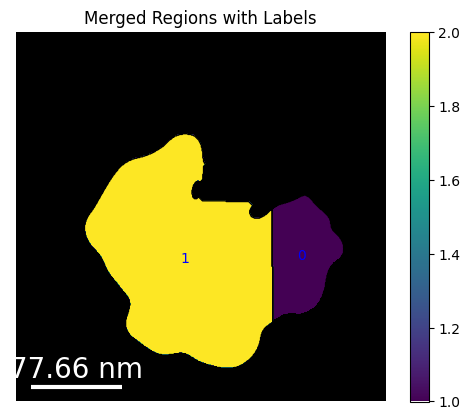

In [33]:
fig

# <a id='binary_mask_HAADF'></a> 6. Overlayed HAADF image with binary mask

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs
from skimage import measure

# Assuming HAADF and roi are already defined
HAADF_image = HAADF.data

# Merge the segmented regions into a single image
merged_image = np.zeros_like(roi[0].T.data)  # Ensure the base image is the correct size

# Assign unique labels to each region based on their order, starting from 0
for i, region in enumerate(roi):
    # Use the region data as a mask to set values in the merged image
    merged_image[region.data > 0] = i + 1  # Label regions from 1 to n

# Create a HyperSpy signal from the merged image
merged_signal = hs.signals.Signal2D(merged_image)

# Set a fixed figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Display the HAADF image
ax.imshow(HAADF_image, cmap='gray', aspect='auto')

# Overlay the labeled image with transparency
im = ax.imshow(merged_signal.data, cmap='viridis', alpha=0.3, aspect='auto')

# Optionally, add a colorbar to help interpret the labels
fig.colorbar(im, ax=ax)

# Add labels to each region
for i, region in enumerate(roi):
    x, y = np.where(merged_signal.data == i + 1)  # Adjust index for 1-based labels
    if x.size > 0 and y.size > 0:  # Check if the region is not empty
        ax.text(y.mean(), x.mean(), str(i), color='blue', ha='center', va='center', fontsize=10, zorder=3)

# Add black edges around each region
for i in range(1, len(roi) + 1):  # Start from 1 to skip background (0)
    region = merged_signal.data == i
    contours = measure.find_contours(region, 0.5)  # Find contours at the boundary
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color='black', linewidth=1, zorder=5)  # Draw the contour

# Calculate scale bar length in pixels
pixel_size = HAADF.axes_manager[0].scale  # nm/pixel
desired_scale_bar_length_nm = round((HAADF.data.shape[1] * HAADF.axes_manager[0].scale) / 4, 2)  # nm
scale_bar_length_px = int(desired_scale_bar_length_nm / pixel_size)

# Draw the scale bar on the image
x_start = 20
y_start = HAADF_image.shape[0] - 20  # Adjusted to fit the text above

# Add a black background rectangle for the scale bar
#scale_bar_bg_height = 30  # Height of the background rectangle
#ax.add_patch(plt.Rectangle((x_start, y_start - scale_bar_bg_height), scale_bar_length_px, scale_bar_bg_height,
#                           color='black', zorder=6))

# Draw the scale bar
ax.hlines(y=y_start, xmin=x_start, xmax=x_start + scale_bar_length_px, colors='white', linewidth=3, zorder=7)
# Add text label for the scale bar above the bar
ax.text(x_start + scale_bar_length_px / 2, y_start - 5, f'{desired_scale_bar_length_nm} nm',
        color='white', ha='center', va='bottom', fontsize=20, zorder=7)

# Hide the axis
plt.axis('off')

# Set title and show the plot
ax.set_title('Overlay of Labeled Image on HAADF Image')

# Prevent resizing of the plot with the window
fig.tight_layout(pad=0)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

# Save the plot and images
# fig.savefig(name + '__Labeled image.png', bbox_inches='tight', pad_inches=0, overwrite=True)
# merged_signal.save(name + '__Binary mask.tif', overwrite=True)
# HAADF.save(name + '__HAADF.tif', overwrite=True)


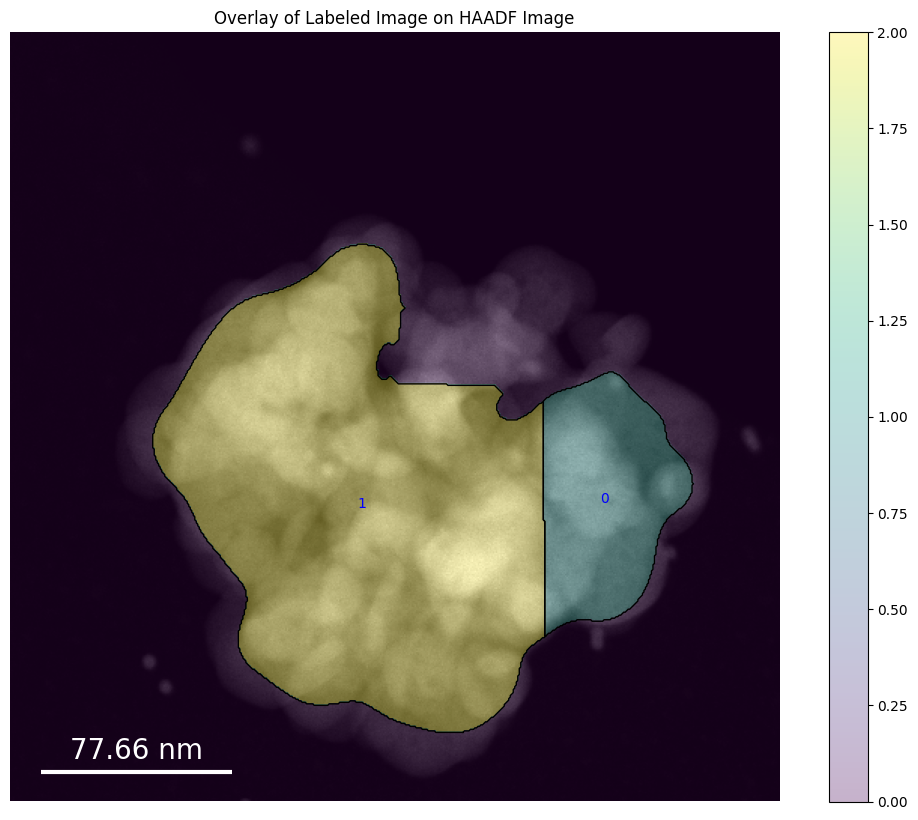

In [35]:
fig

# <a id='colour_mask'></a> 7. Colour labeled segmentation based on chemical compisition

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from skimage import measure
from matplotlib.patches import Rectangle

# Example arrays for demonstration
# Assuming 'HAADF' and 'merged_signal' are Hyperspy Signal2D objects
HAADF_image = HAADF.data  # Replace with your actual image data
merged_signal = np.asarray(merged_signal)  # Convert to NumPy array if it's a memoryview

# Example array for demonstration , this array is used to color label each region, you can obtain the array 
 #based on chemical composition from the exported excel file then paste it here
array = [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1]

# Create a custom colormap based on the binary array
colors = [(0, 0, 0, 0)]  # RGBA for transparent
colors += [('red' if value == 0 else 'green' if value == 1 else 'yellow') for value in array]
cmap = ListedColormap(colors)

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 8))  # Set figure size here

# Display the HAADF image
ax.imshow(HAADF_image, cmap='gray', aspect='auto')

# Overlay the labeled image with custom colors
im = ax.imshow(merged_signal, cmap=cmap, alpha=0.4, aspect='auto', zorder=1)  # Adjust alpha for more/less transparency

# Add a colorbar to help interpret the labels
cbar = fig.colorbar(im, ax=ax, ticks=[i + 0.5 for i in range(len(colors))])
cbar.ax.set_yticklabels(['BG'] + list(range(len(array))))  # Set labels for colorbar, starting with background

# Draw black edges around each region and add labels
for i in range(1, len(array) + 1):  # Start from 1 to skip background (0)
    region = merged_signal == i
    contours = measure.find_contours(region, 0.5)  # Find contours at the boundary

    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color='black', linewidth=1, zorder=2)  # Draw the contour

    # Calculate the center of the region for labeling
    y_coords, x_coords = np.where(region)
    if y_coords.size > 0 and x_coords.size > 0:  # Check if the region is not empty
        # Calculate mean position for label
        y_mean, x_mean = np.mean(y_coords), np.mean(x_coords)
        ax.text(x_mean, y_mean, str(i), color='blue', ha='center', va='center', fontsize=10, weight='bold', zorder=2)

# Calculate scale bar length in pixels
pixel_size = HAADF.axes_manager[0].scale   # nm/pixel
desired_scale_bar_length_nm = round((HAADF.data.shape[1]*HAADF.axes_manager[0].scale)/4,2)  # nm
scale_bar_length_px = int(desired_scale_bar_length_nm / pixel_size)



# Draw the scale bar on the image
x_start = 20
y_start = HAADF_image.shape[0] - 10  # Adjusted to fit the text above

# Draw a black rectangle as the background for the scale bar
#rect_height = 20  # height of the rectangle
#rect = Rectangle((x_start, y_start - rect_height), scale_bar_length_px, rect_height, color='black', zorder=3)
#ax.add_patch(rect)

# Draw the scale bar
ax.hlines(y=y_start, xmin=x_start, xmax=x_start + scale_bar_length_px, colors='white', linewidth=5, zorder=4)
# Add text label for the scale bar above the bar
ax.text(x_start + scale_bar_length_px / 2, y_start - 5, f'{desired_scale_bar_length_nm} nm', color='white', ha='center', va='bottom', fontsize=25, zorder=4)

# Hide the axis
plt.axis('off')

# Set the aspect ratio to be equal
ax.set_aspect('equal', adjustable='box')

# Set title and show the plot
ax.set_title('Labeled HAADF Image with Conditional Colors based on I/Pb atomic concentration ratio: \n red (I/Pb<2.5), green (2.5<I/Pb<3.5), yellow (3.5<I/Pb)')

# Show the plot
plt.show()


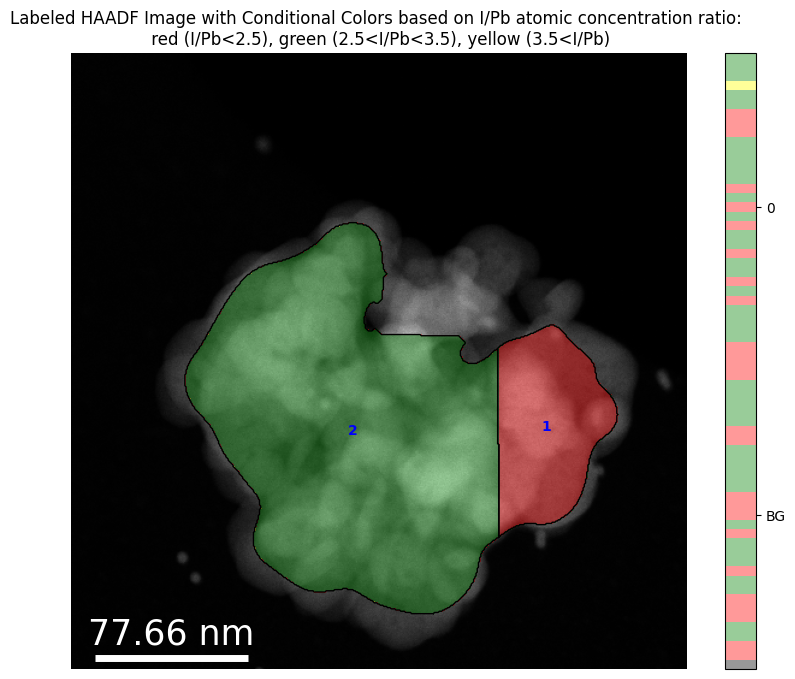

In [37]:
fig